# The Decay Chain of $^{220}$Radon:  a simple Monte Carlo

The decay chain of Radon is shown below
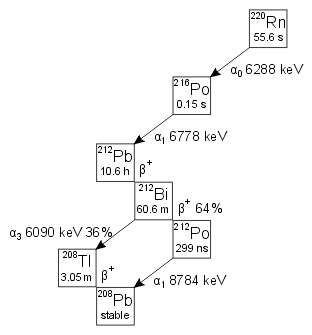


(The $\beta$'s are actually $\beta^-$ and not $\beta^+$.)

If we start with a number of radon atoms N, in a closed environment, what is the time evolution of each of the subsequent species?

We can integrate the time evolution with a set of coupled differential equations and use odeint.  But setting the problem up in MC gives us several advantages:

1.  Once we have the framework in place, we can answer a very broad range of questions- like "what is the time distribution during which the system has one (or any othe number we care to pick) Thallium atoms?" 
2.  It enables us to test statistics in a rigorous manner; and doing statistical tests within a MC framework is simple.
3.  It allows us to simply change the initial conditions.  
4.  For large dimensional problems, or problems with complex boundary conditions, MC is often much easier than multidimensional integration.

The way we write the MonteCarlo is to follow the history of each particle.  In principle we can't do it- because we can't predict when any particular atom will decay- but we can generate an equivalent history for each atom.  

Let's start by throwing the time a particular Radon atom will decay.  The halflife of radon is 55 seconds, and the probability that a radon decays in an interval of time $dt$ is a constant- $\lambda dt$.  We define $P(t)$ as the probability a radon survives to time $t$. Then the probability it survives to $t+dt$ is the probability it survives to $t$ times the probability it doesn't decay in time dt:
\begin{equation}dP(t+dt)=P(t)(1-\lambda dt)\rightarrow \frac{dP}{dt}=-P\lambda\rightarrow P=P_0 e^{-\lambda t}\end{equation}

We set $P_0$ by requiring the integrated probabilty distribution to be 1:
\begin{equation}1=\int_0^\infty P_0 e^{-\lambda t}=\frac{P_0}{\lambda}\end{equation}

and we find $\lambda$ because the ''half-life'' is the time at which probability of survival is 1/2:
\begin{equation}\frac{P_0}{2}=P_0 e^{-\lambda t_{1/2}}\rightarrow \lambda=\frac{log(2)}{t_{1/2}}\end{equation}

so in the end we have

\begin{equation}P(t)=\lambda e^{-\lambda t}\end{equation}

Note that half-lives are used in nuclear physics.  In particle physics and atomic physics decay rates $1/\lambda$ are typically used.  Most computer programs follow the "log means natural log" convention.  

Let's start by plotting the lifetime distribution of a radon:


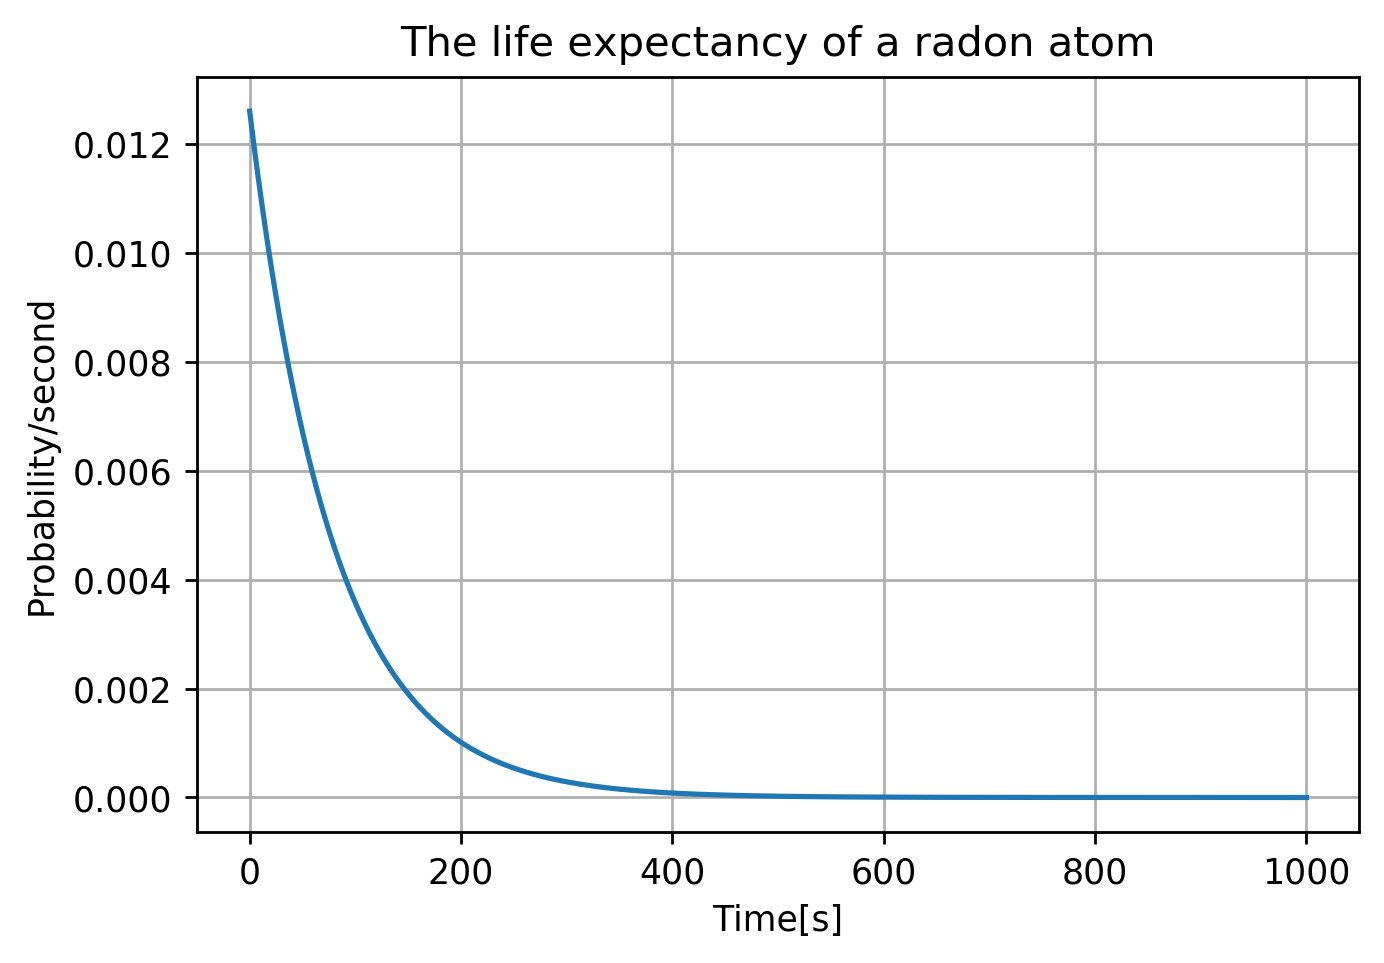

In [4]:
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

lambdaRn=np.log(2)/55
plt.title('The life expectancy of a radon atom')
plt.xlabel('Time[s]')
plt.ylabel('Probability/second')
t=np.linspace(0,1000,1000)
p=lambdaRn*np.exp(-lambdaRn*t)
plt.plot(t,p)
plt.grid()


### Throw and test technique for generating a random number distribution
The easiest way to pick events according to this probability distribution is to throw a random time- uniformly between 0 and 1000 s, and then throw a second random number between 0 and lambda.  If the number is less than or equal to the probability distribution, we keep that time; otherwise throw again.  

Do it for 100000 events and plot the time distribution:


In [5]:
d=np.random.rand(1000000,2)*np.array([1000,lambdaRn]) #throw 1 million pairs of random numbers
print(d[:10,:])
tdist=d[ np.where(lambdaRn*np.exp(-lambdaRn*d[:,0])>d[:,1]) ,0].reshape(-1)
print(tdist)
print(tdist.shape)

[[1.58894329e+02 6.62780349e-03]
 [4.23479357e+02 9.95160086e-03]
 [8.12792104e+02 4.41898115e-03]
 [2.65567774e+02 4.63526218e-03]
 [7.98811146e+00 1.13967733e-02]
 [8.59914289e+02 8.80783499e-03]
 [8.85514598e+02 1.47152497e-03]
 [3.98002092e+02 1.22476956e-02]
 [6.23528523e+02 1.99728868e-03]
 [4.74829006e+02 5.19717044e-03]]
[278.57367597  30.66331294  15.71830926 ... 192.52998402 136.47464554
  15.28646257]
(79109,)


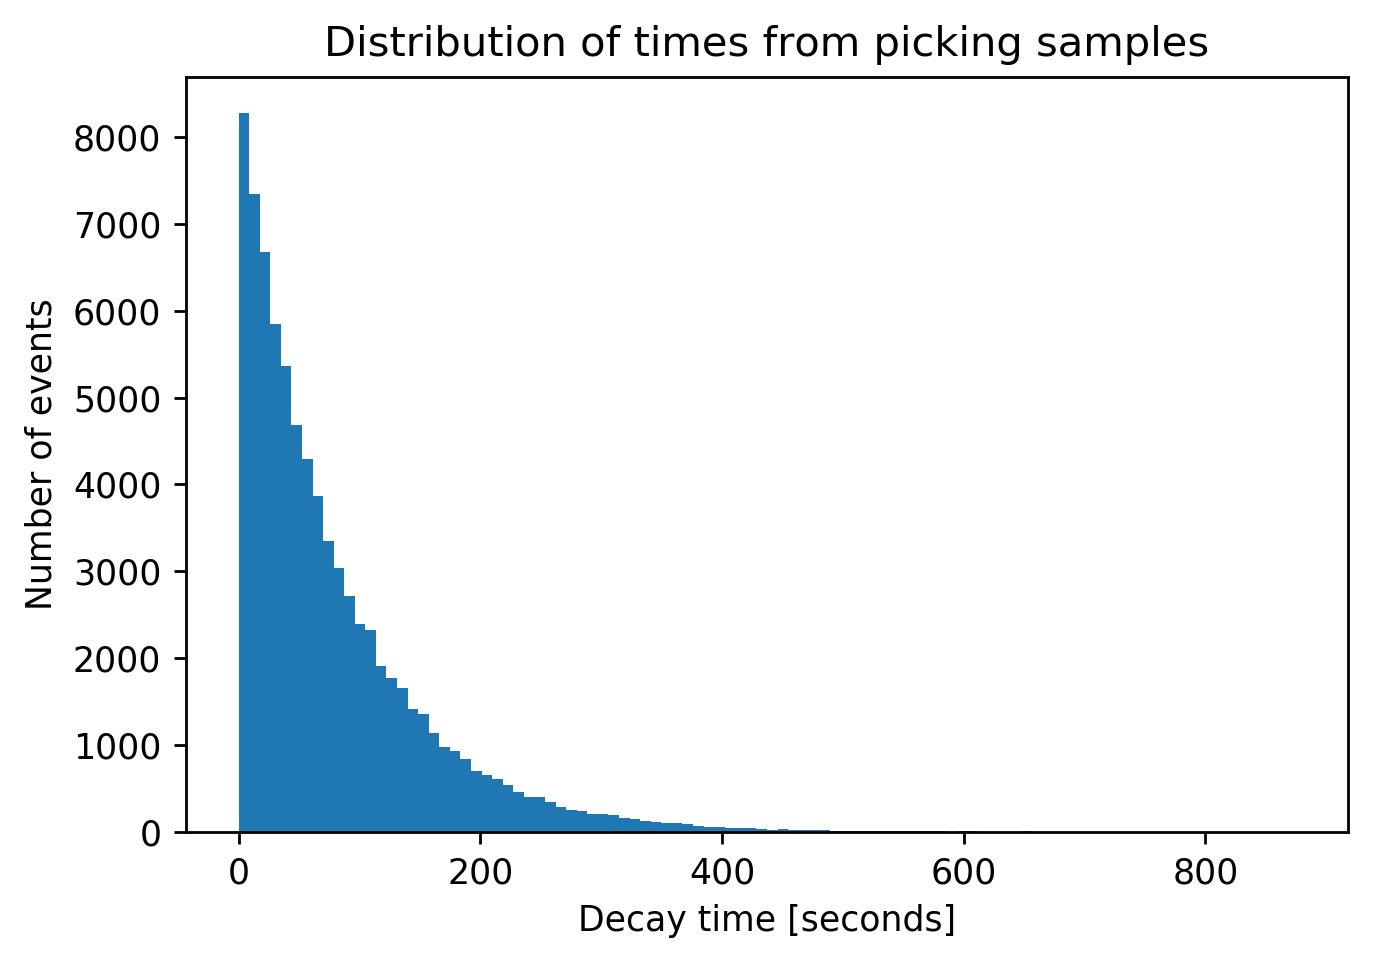

In [6]:
plt.figure()
plt.hist(tdist,100)
plt.title('Distribution of times from picking samples')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.show()


This is not particularly efficient; it also defines a "false" cutoff at 1000 second.  For many distributions (especially if we have nice analytical forms)  we are better off throwing the probability, and then finding the decay time that corresponds to that probability.  So if $R$ is a random number between 0 and 1, we solve the equation:
\begin{equation}\lambda\int_0^t exp^{-\lambda t'}dt'=R\rightarrow t=-\frac{\log(1-R)}{\lambda}\end{equation}

Since R is a random number between 0 and 1, 1-R is also a random number between 0 and 1, and so we don't need to do the subtraction.  
Now generate and histogram 1 million events this way:

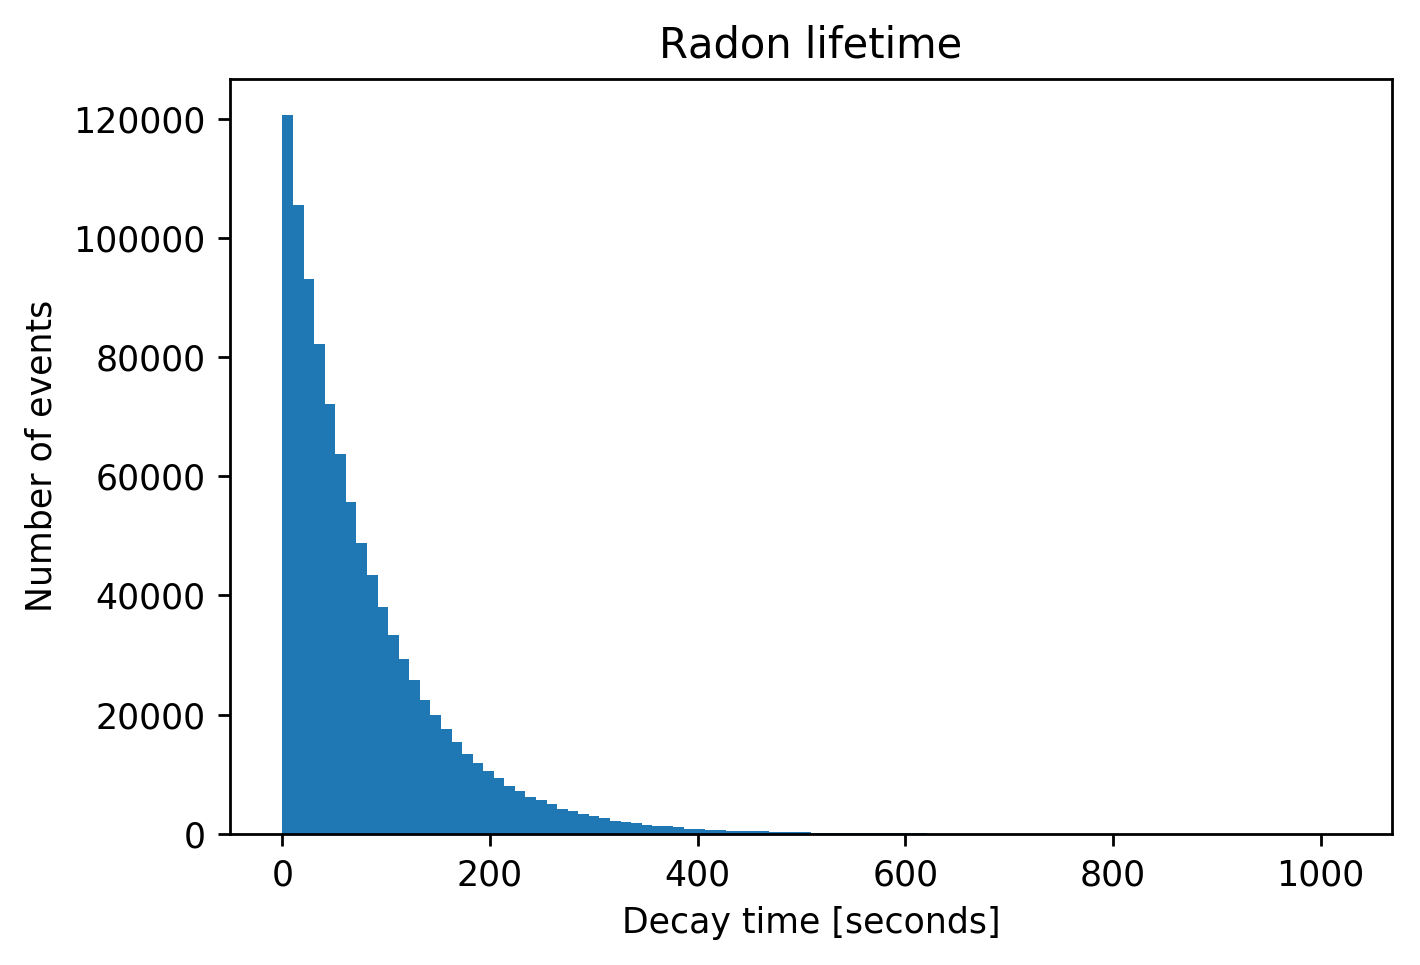

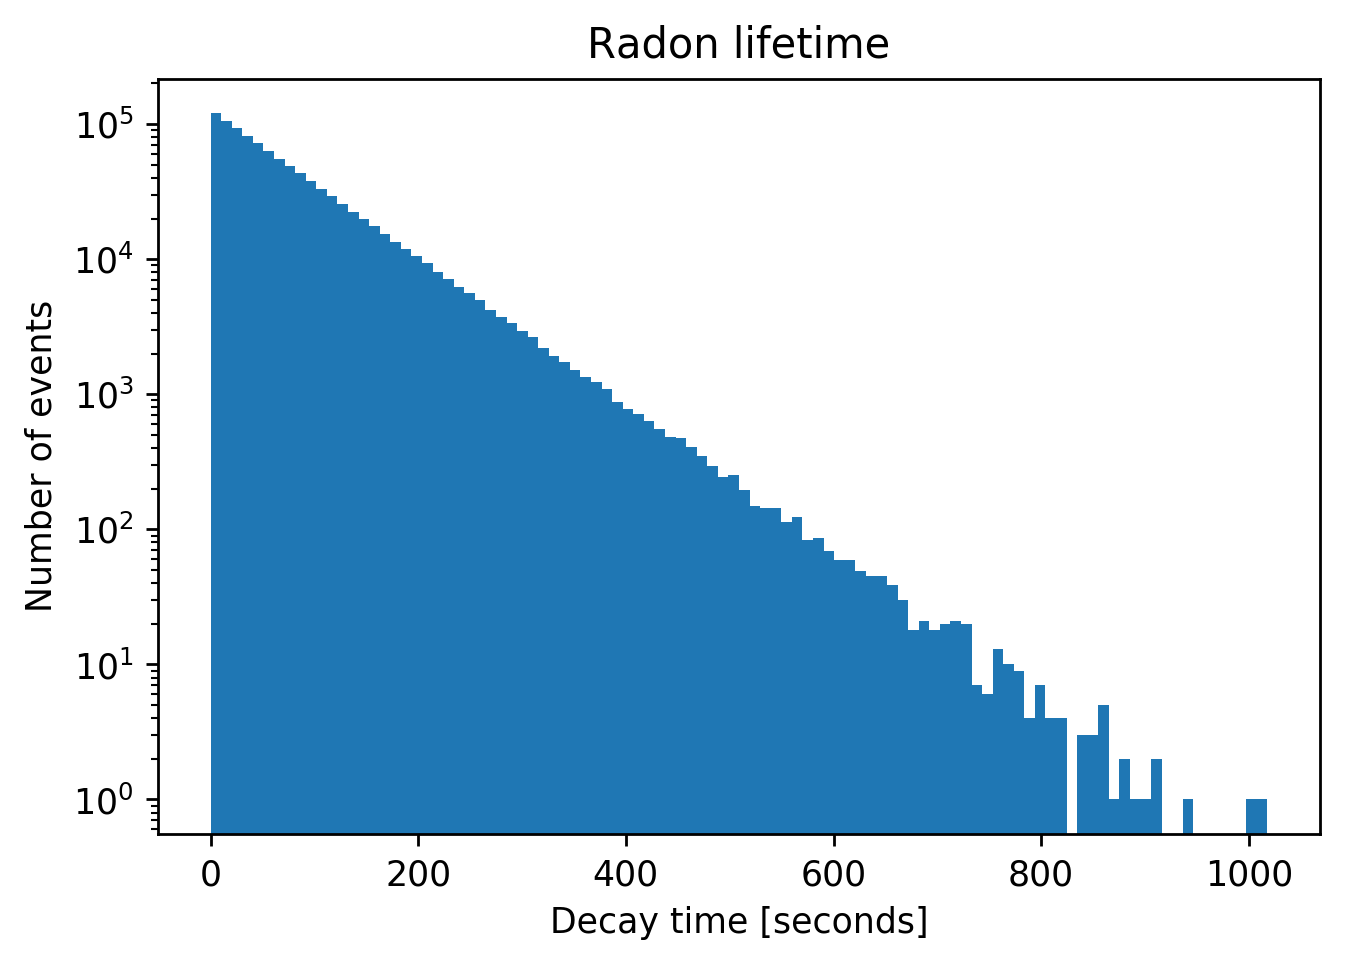

In [20]:
d=np.random.rand(1000000)
t=-np.log(d)/lambdaRn
plt.figure()
plt.hist(t,100)
plt.title('Radon lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.show()
plt.figure()
plt.yscale('log')
plt.hist(t,100)
plt.title('Radon lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.show()

It turns out that for common distributions, this technique is already built into numpy.  

In [21]:


help(np.random)

Help on package numpy.random in numpy:

NAME
    numpy.random

DESCRIPTION
    Random Number Generation
    
    ==================== =========================================================
    Utility functions
    random_sample        Uniformly distributed floats over ``[0, 1)``.
    random               Alias for `random_sample`.
    bytes                Uniformly distributed random bytes.
    random_integers      Uniformly distributed integers in a given range.
    permutation          Randomly permute a sequence / generate a random sequence.
    shuffle              Randomly permute a sequence in place.
    seed                 Seed the random number generator.
    choice               Random sample from 1-D array.
    
    ==================== =========================================================
    
    ==================== =========================================================
    Compatibility functions
    rand                 Uniformly distributed values.
    randn

In [22]:
help(np.random.exponential)

Help on built-in function exponential:

exponential(...) method of mtrand.RandomState instance
    exponential(scale=1.0, size=None)
    
    Draw samples from an exponential distribution.
    
    Its probability density function is
    
    .. math:: f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta}),
    
    for ``x > 0`` and 0 elsewhere. :math:`\beta` is the scale parameter,
    which is the inverse of the rate parameter :math:`\lambda = 1/\beta`.
    The rate parameter is an alternative, widely used parameterization
    of the exponential distribution [3]_.
    
    The exponential distribution is a continuous analogue of the
    geometric distribution.  It describes many common situations, such as
    the size of raindrops measured over many rainstorms [1]_, or the time
    between page requests to Wikipedia [2]_.
    
    Parameters
    ----------
    scale : float or array_like of floats
        The scale parameter, :math:`\beta = 1/\lambda`.
    size : int or tupl

Now we work through the same example with the built in exponential function:


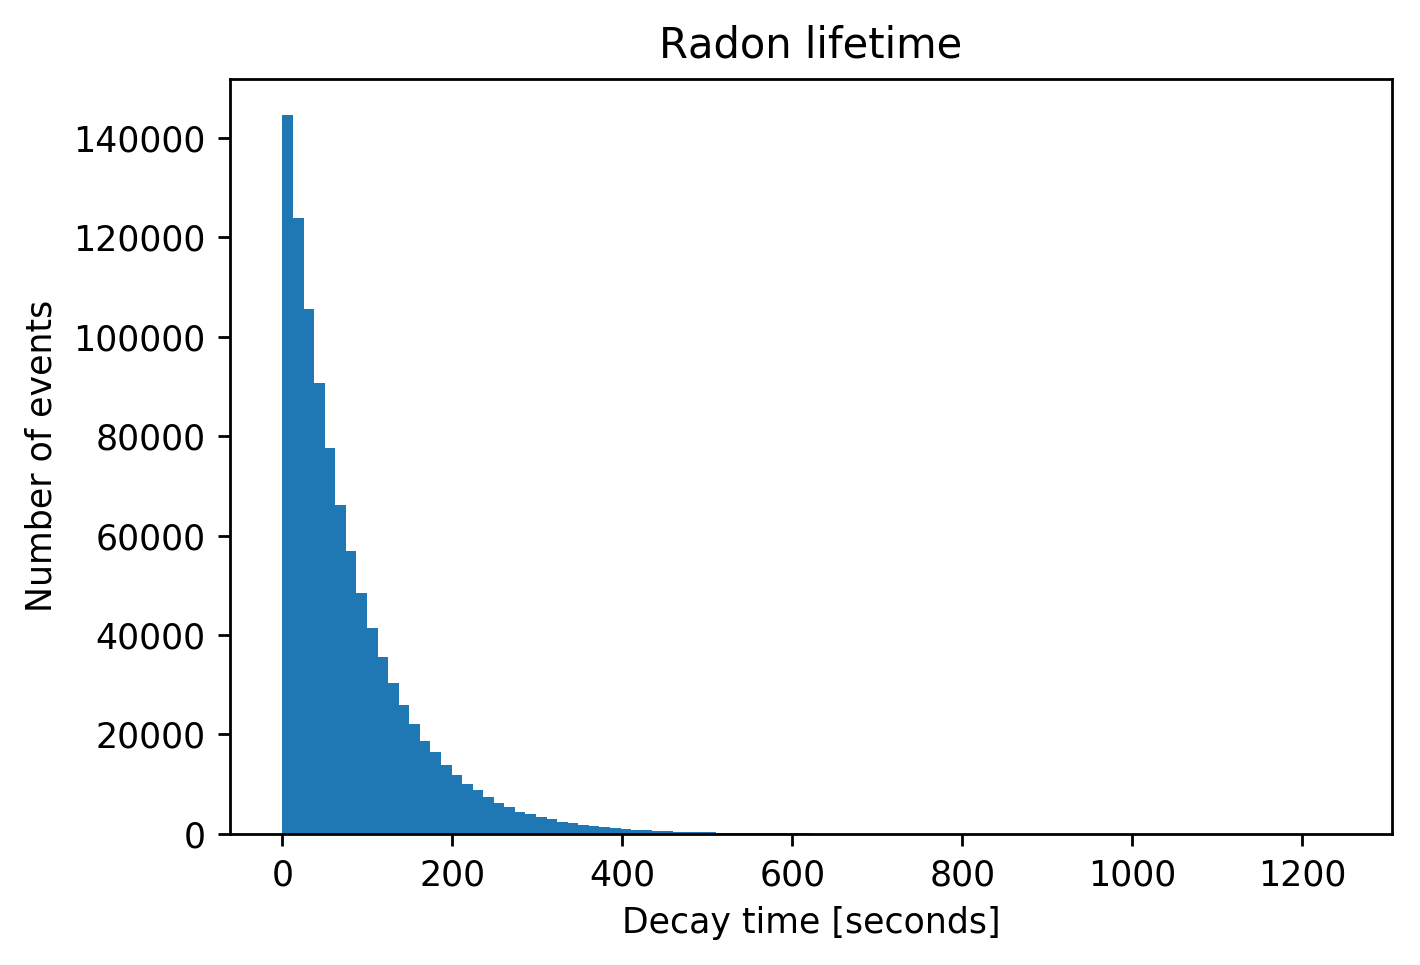

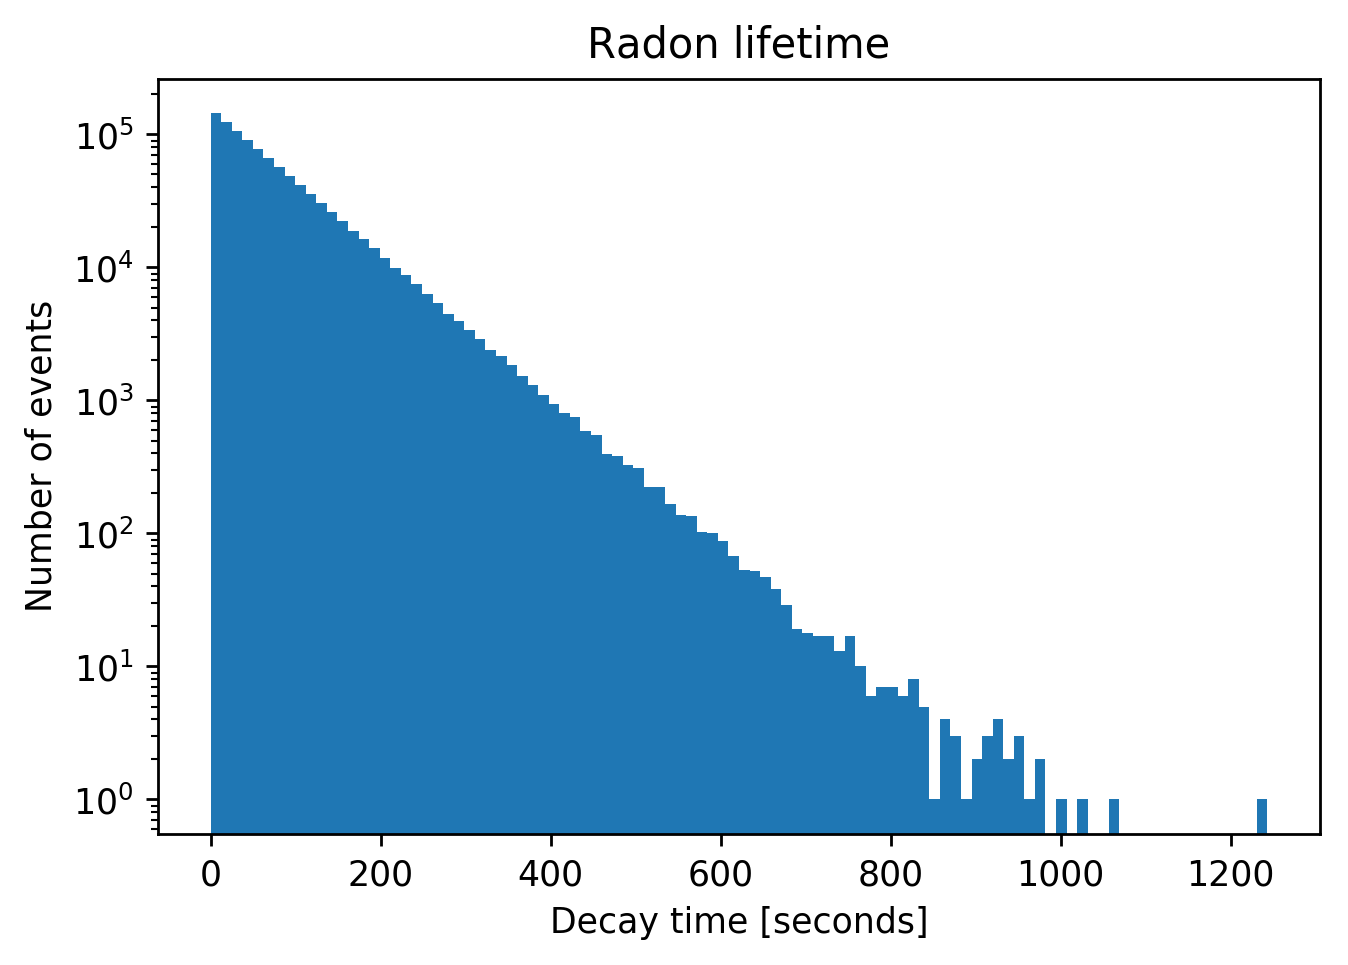

In [23]:
d=np.random.exponential(1/lambdaRn,1000000)
plt.figure()
plt.hist(d,100)
plt.title('Radon lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.show()
plt.figure()
plt.yscale('log')
plt.hist(d,100)
plt.title('Radon lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.show()

Now we have a simulation of the experiment- where we have 1000000 radon atoms, and, - in our simulation- we know exactly when each one decays.  

Look back at the decay chain- the next element is $^{216}$Po, with a half life of 0.15 seconds.  We generate the decay times for each of those atoms as well.  

$^{212}$Pb has a half life of 10.6 hours followed by $^{212}$Bi with a half life of 60.6 m.  

So let us make arrays that contain the lifetimes for each of the 1000000 atoms.

$^{212}$Bi, with a halflife of 60.6 m, has a branch-- 64% of the time it decays to $^{212}$Po, which has a half life of 299 ns, and 36% of the time it decays to $^{208}$Tl with a halflife of 3.05 m.  Both branches come back to $^{208}$Pb, which is stable. 

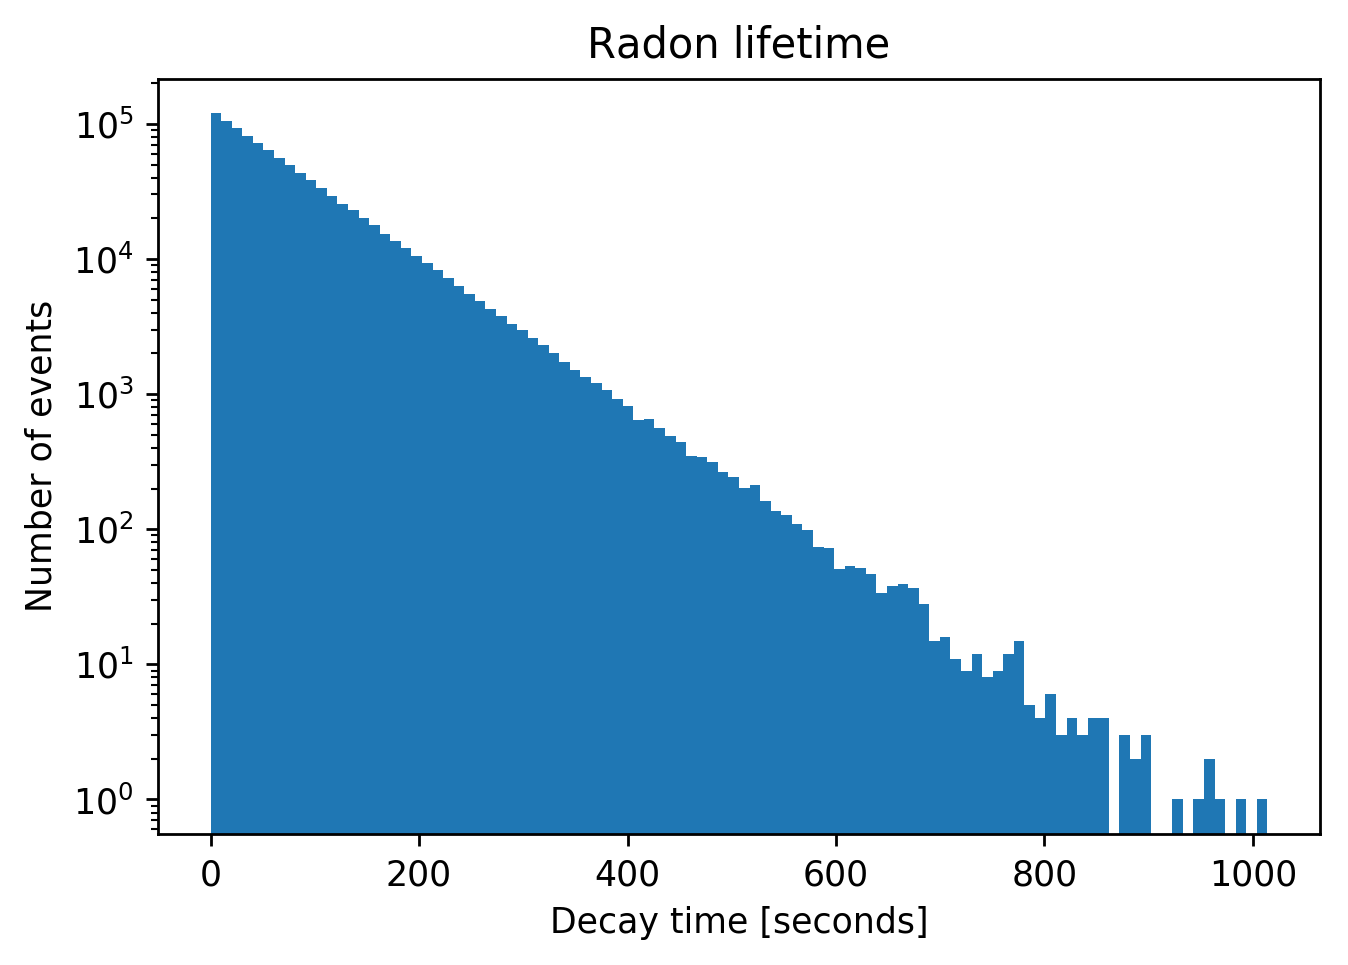

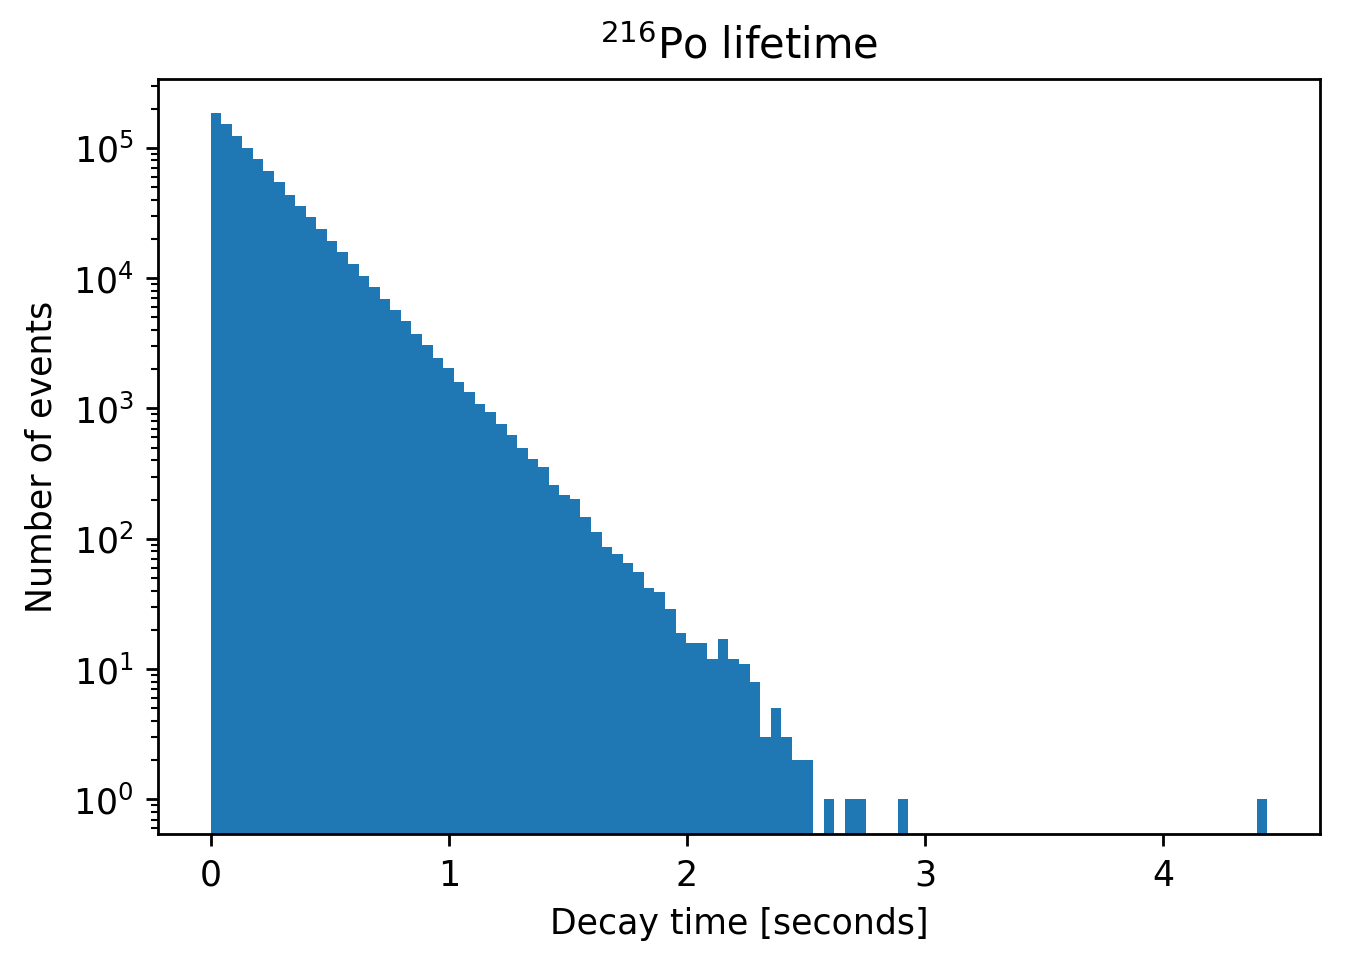

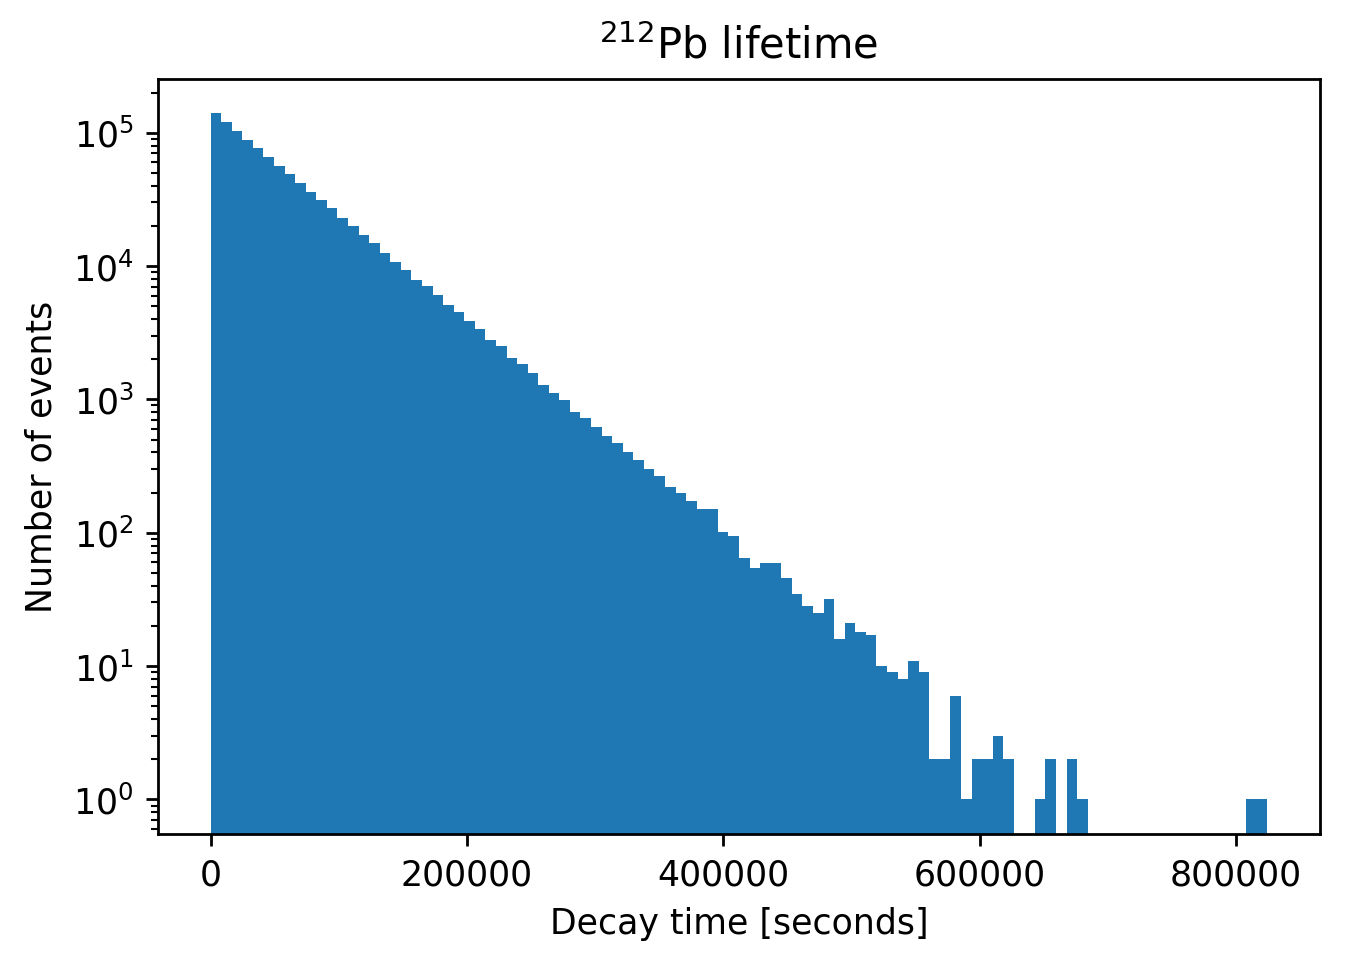

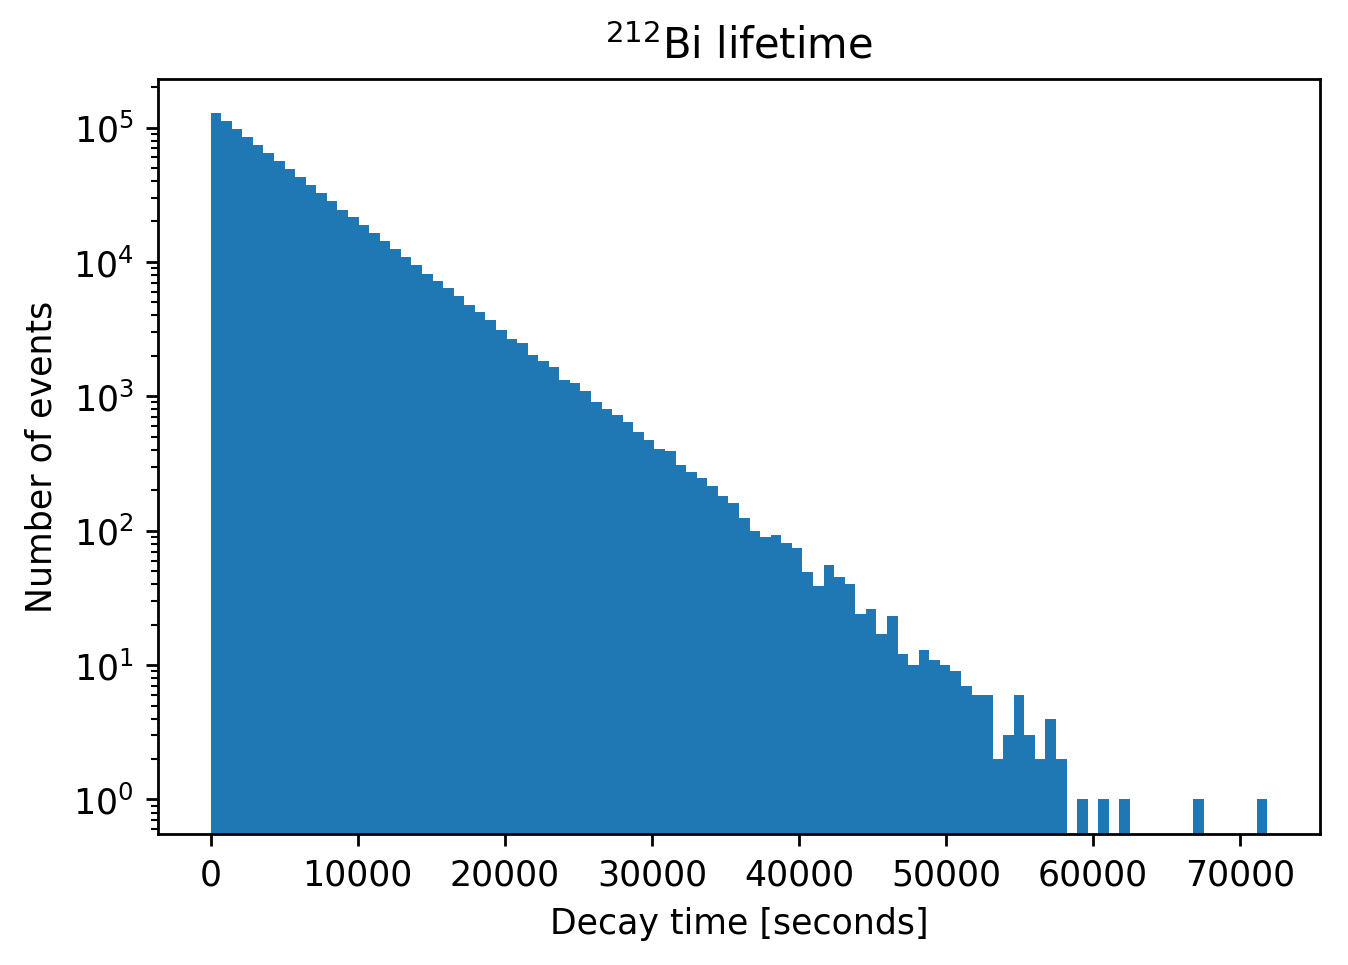

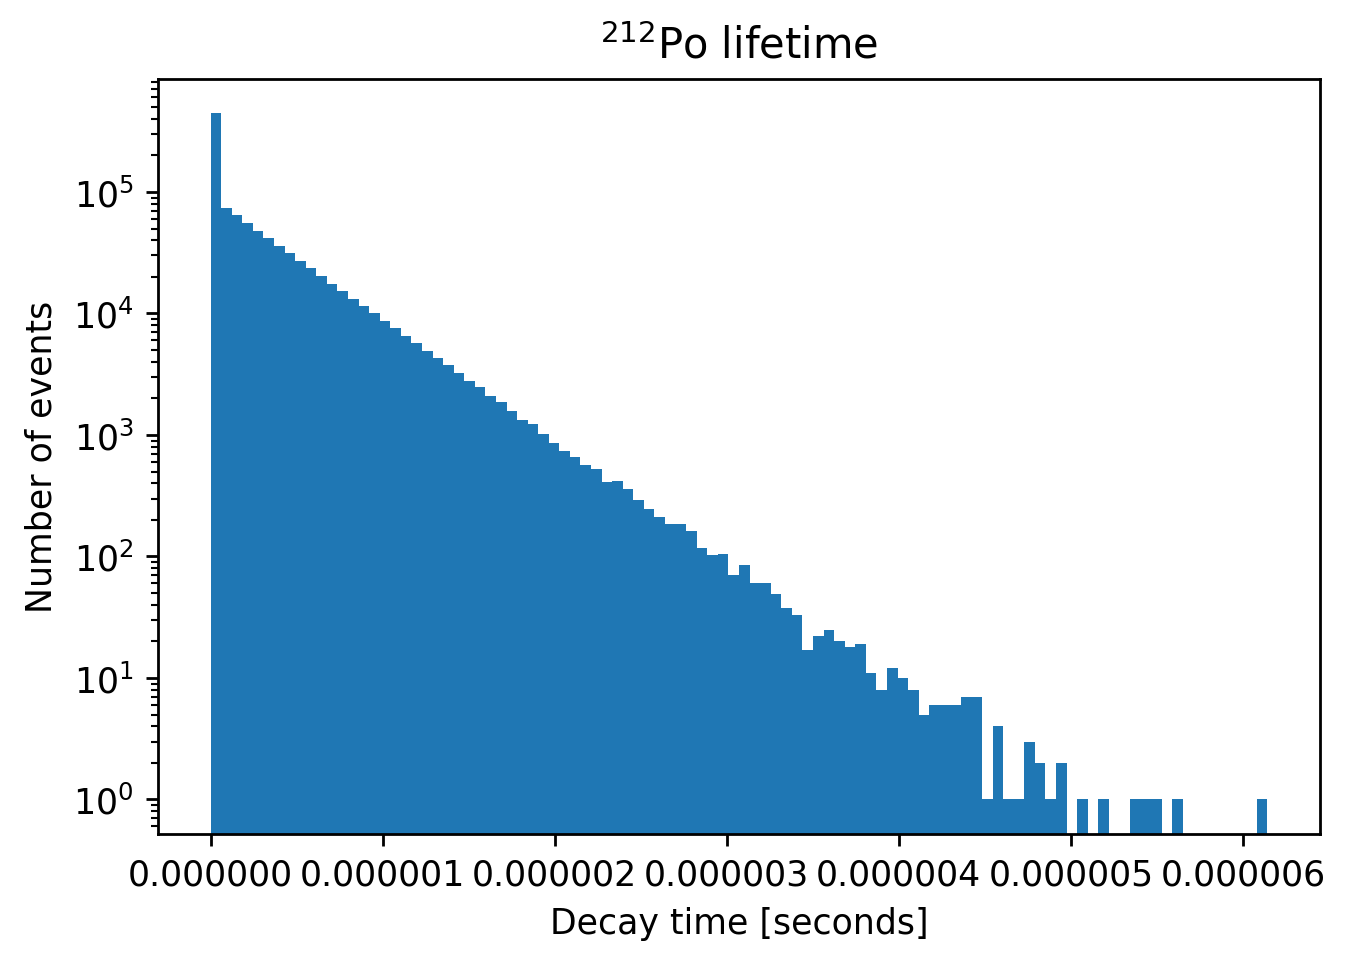

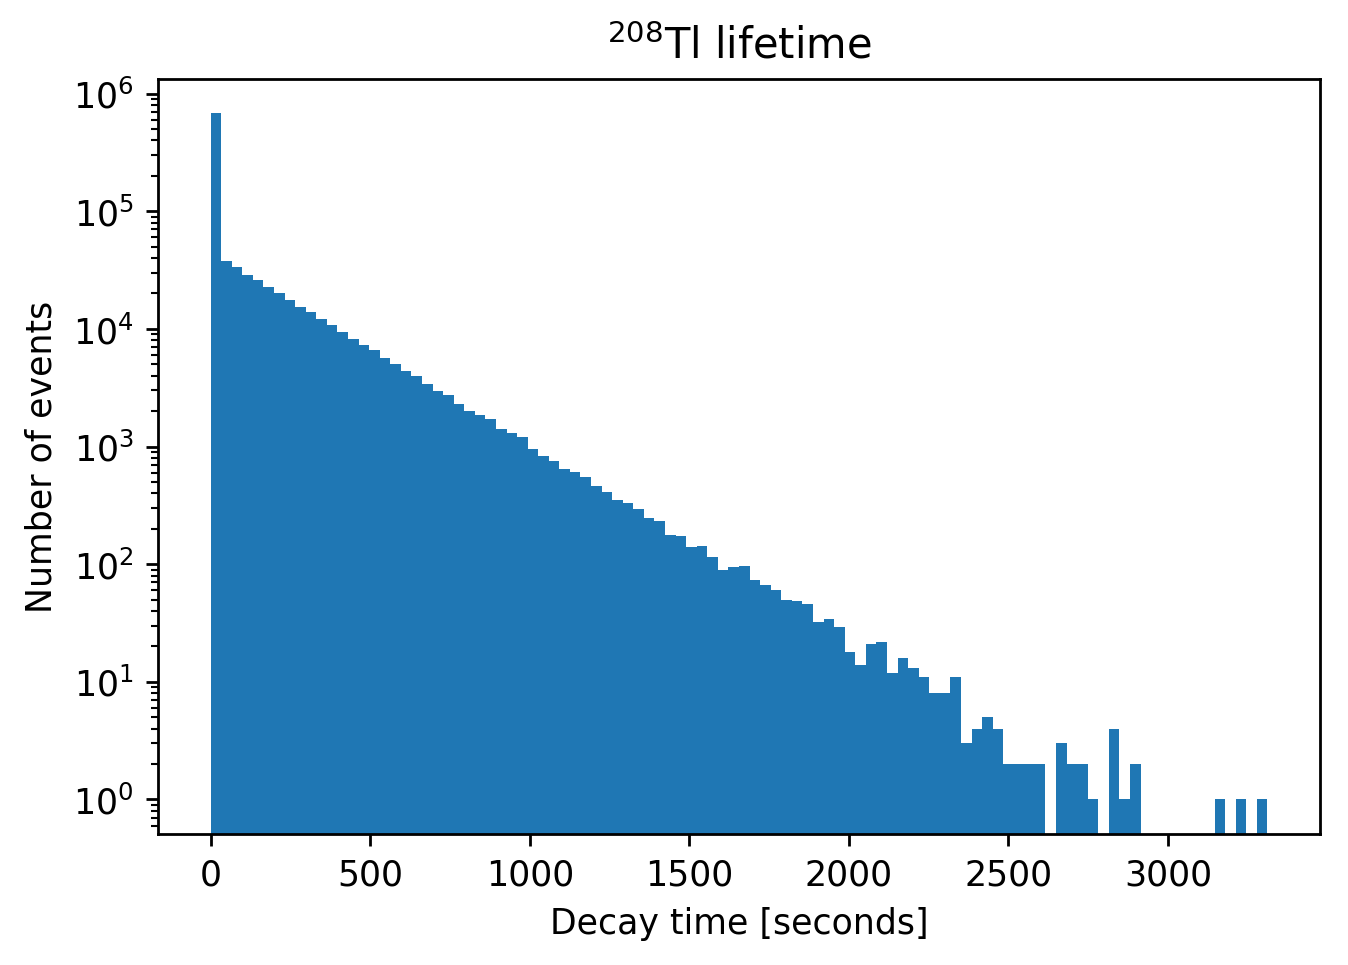

In [24]:
radon=np.random.exponential(1/lambdaRn,1000000)
scalePo216=0.15/np.log(2)
po216=np.random.exponential(scalePo216,1000000)
scalePb212=10.6*3600/np.log(2)
pb212=np.random.exponential(scalePb212,1000000)
scaleBi212=60.6*60/np.log(2)
bi212=np.random.exponential(scaleBi212,1000000)
# here we generate a branch variable, which decides which one of two ways to go
branch=np.random.rand(1000000)
scalePo212=299e-9/np.log(2)
po212=np.random.exponential(scalePo212,1000000)# generate all million to begin with
po212[np.where(branch>=0.64)]=0
scaleTl208=3.05*60/np.log(2)
tl208=np.random.exponential(scaleTl208,1000000)# generate all million to begin with
tl208[np.where(branch<=0.64)]=0

#double check the distributions by plotting them.
plt.figure()
plt.hist(radon,100)
plt.title('Radon lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(po216,100)
plt.title(r'$^{216}$Po lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(pb212,100)
plt.title(r'$^{212}$Pb lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(bi212,100)
plt.title(r'$^{212}$Bi lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(po212,100)
plt.title(r'$^{212}$Po lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(tl208,100)
plt.title(r'$^{208}$Tl lifetime')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()



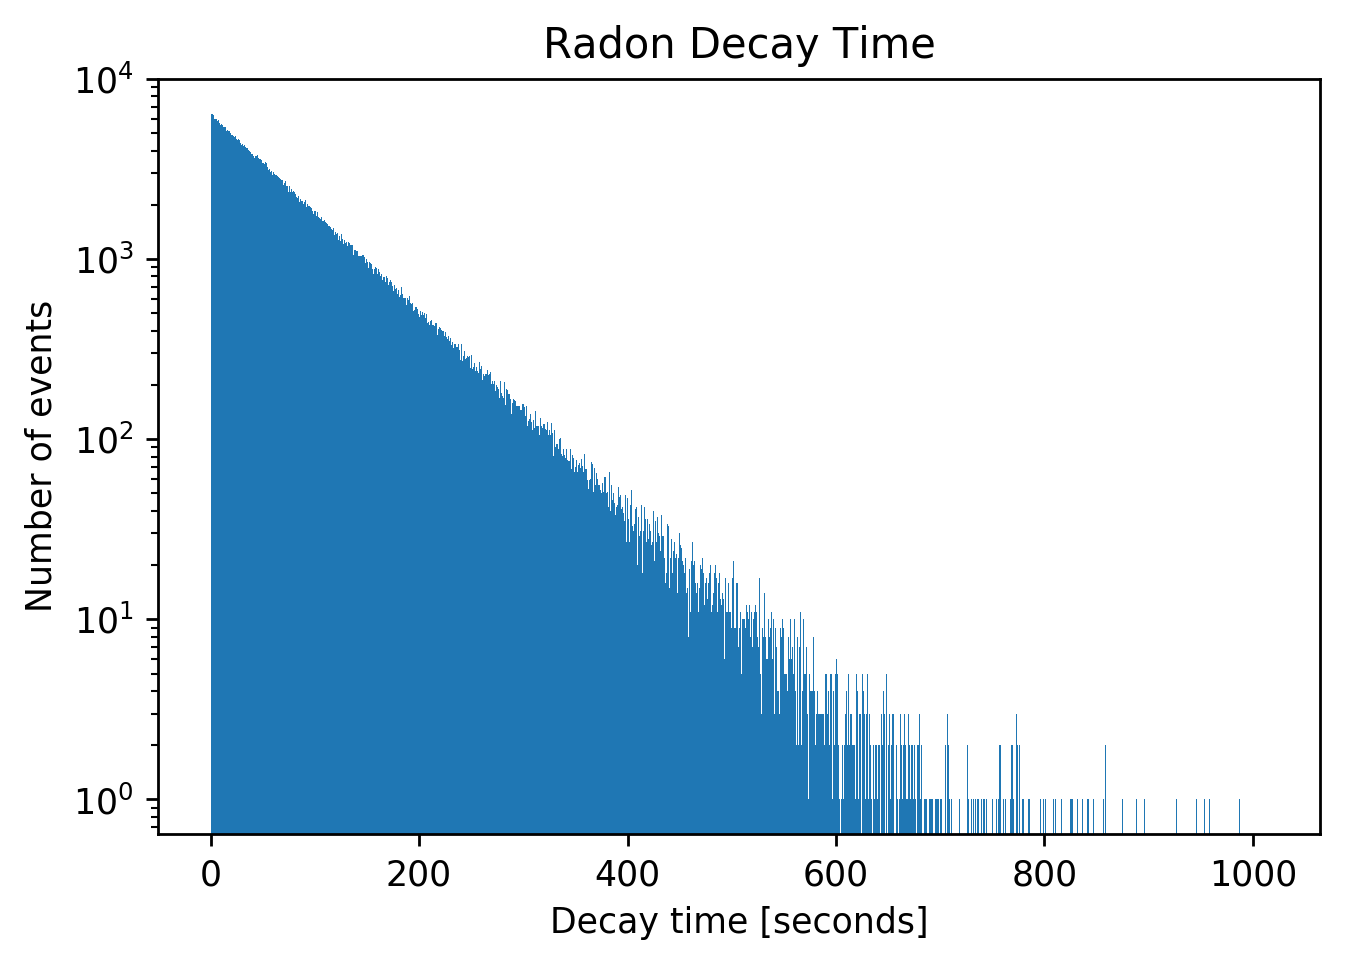

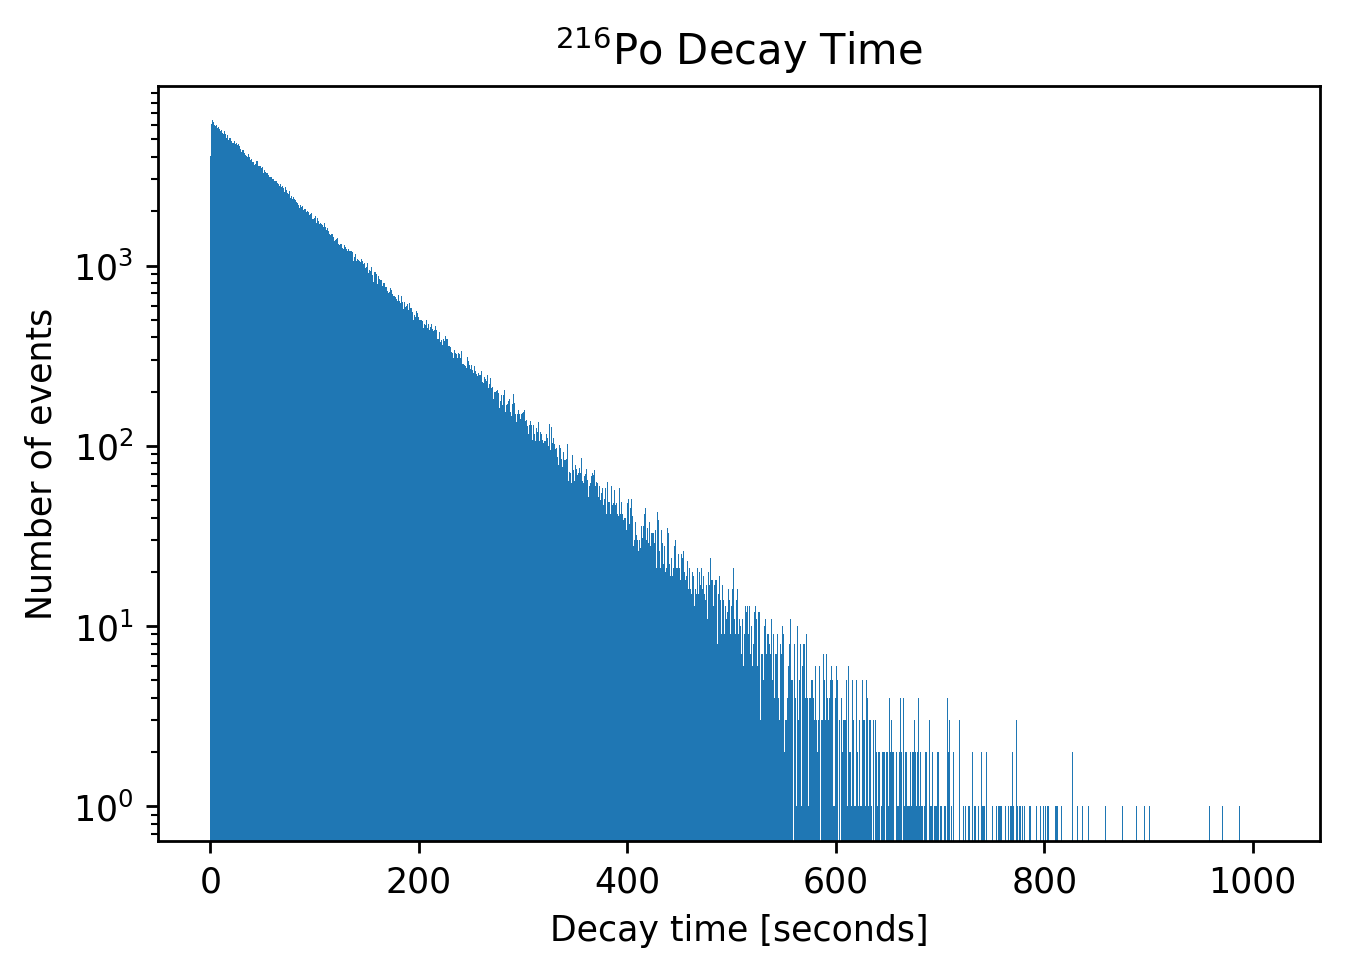

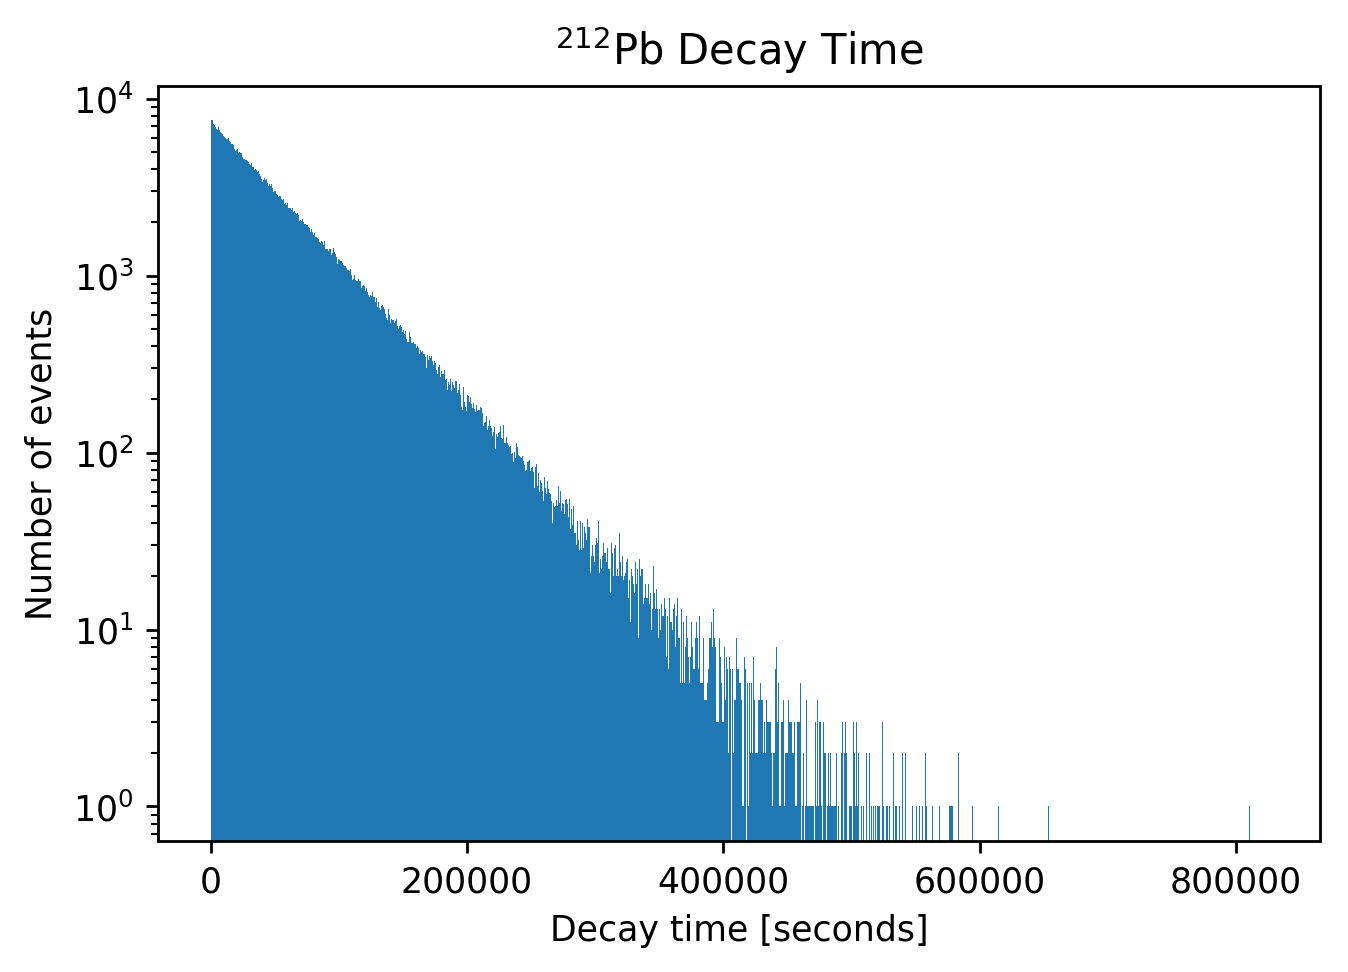

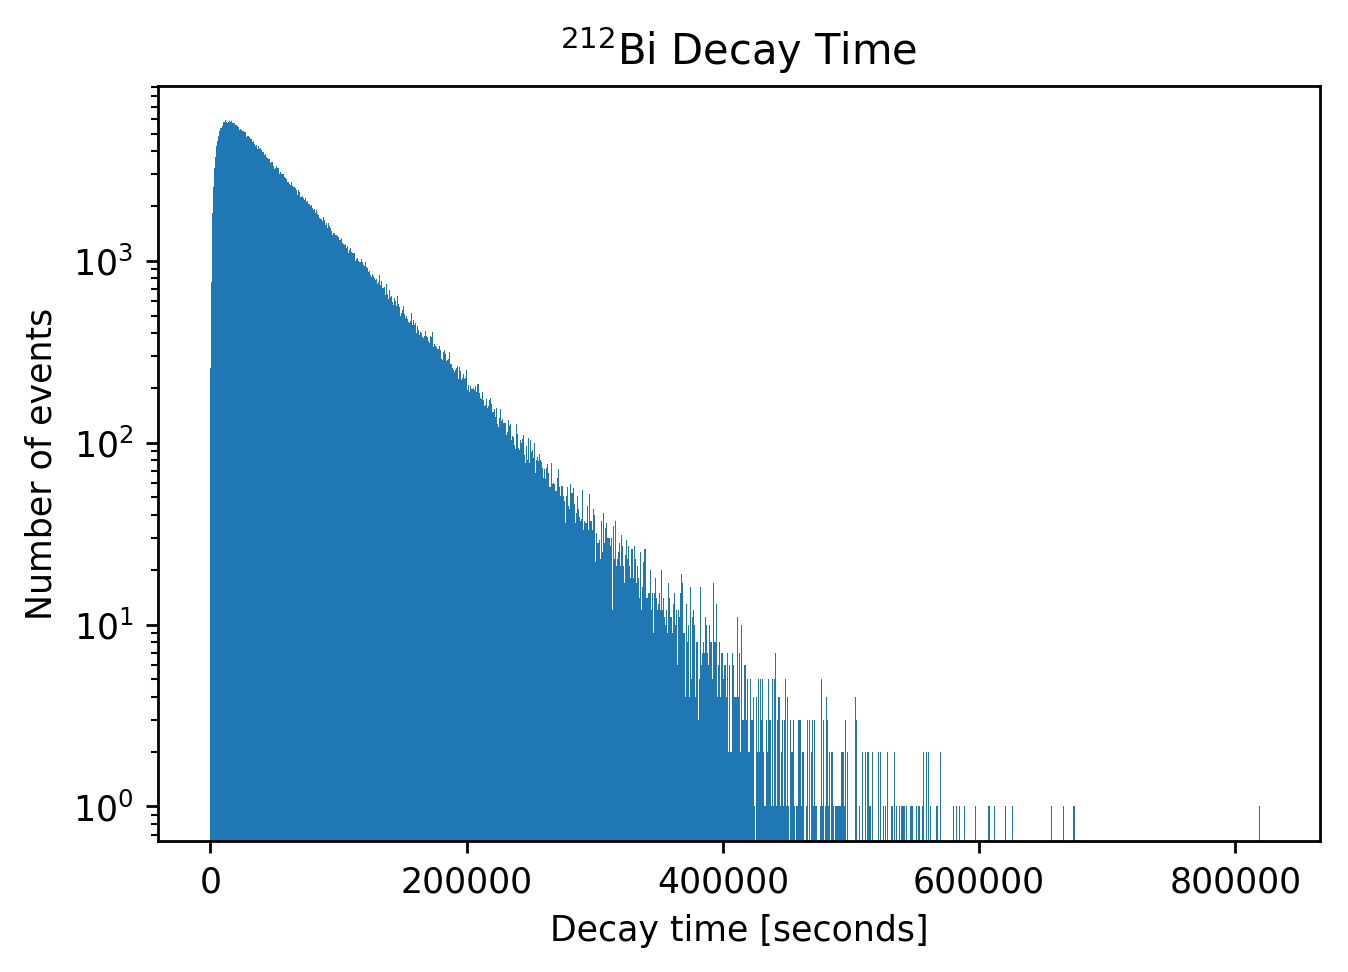

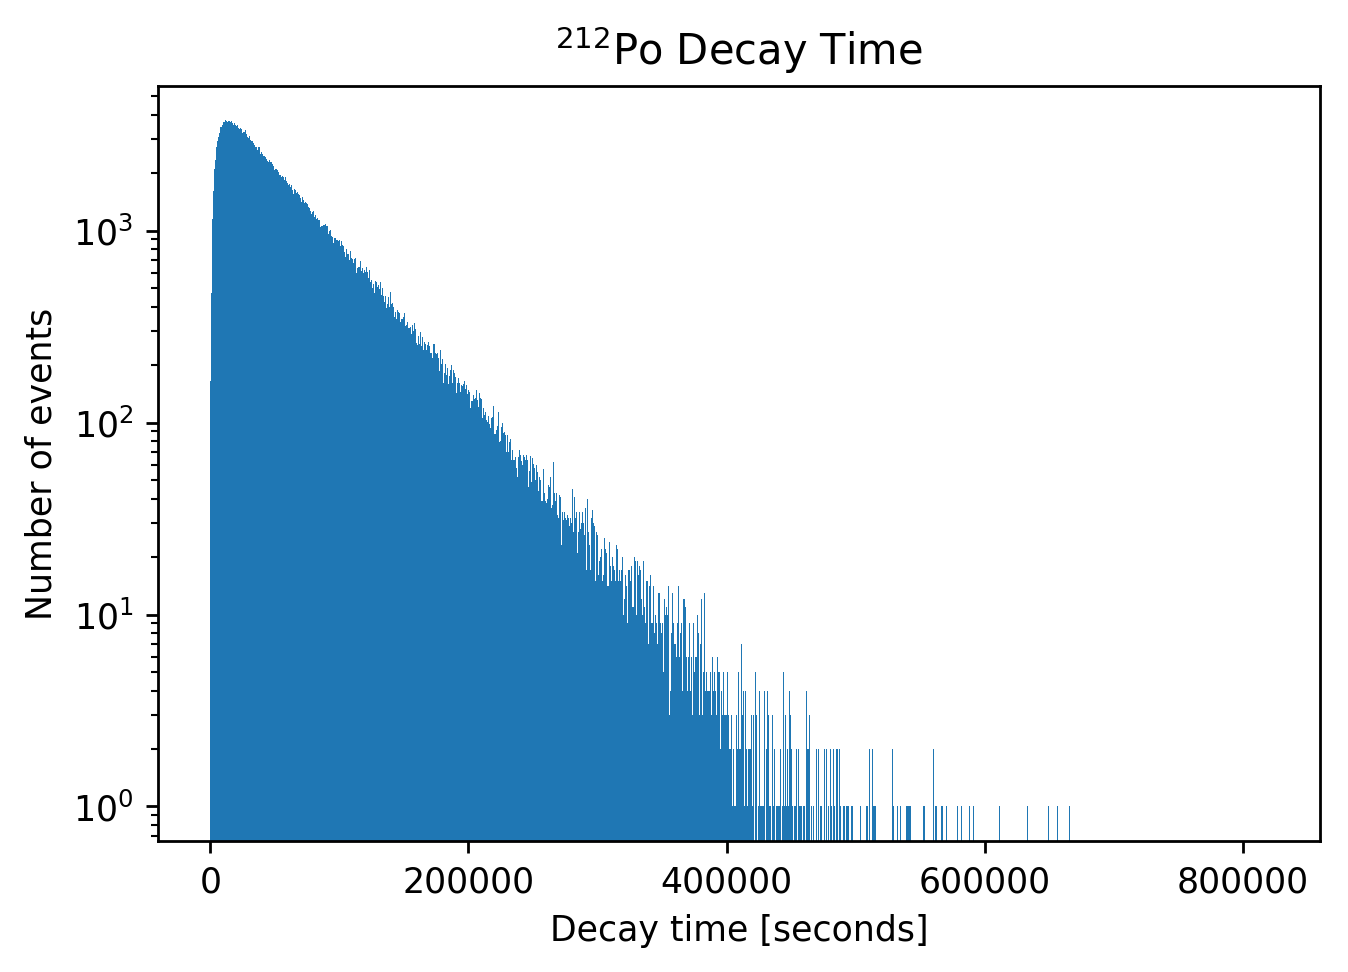

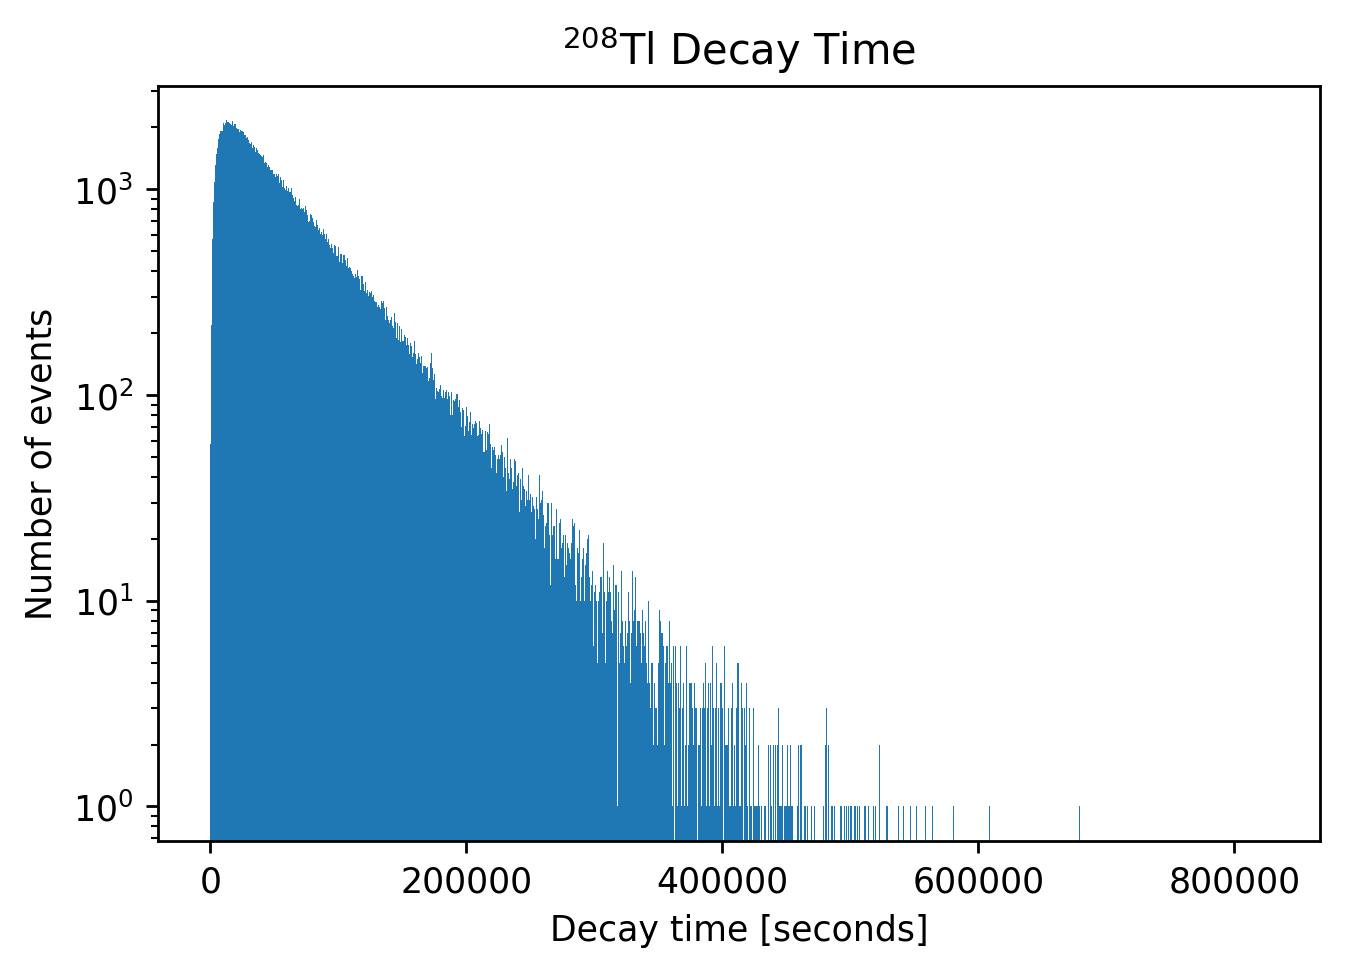

In [25]:
radonDecayTime=radon
po216DecayTime=radon+po216
pb212DecayTime=po216DecayTime+pb212
bi212DecayTime=pb212DecayTime+bi212
po212DecayTime=(bi212DecayTime+po212)[np.where(po212!=0)]  # the bracket removes 0's for events which went to Tl20
tl208DecayTime=(bi212DecayTime+tl208)[np.where(tl208!=0)]  # this includes 0's for events which went to Po212
bipoTime=bi212DecayTime[np.where(po212!=0)]
bitlTime=bi212DecayTime[np.where(tl208!=0)]

plt.figure()
plt.hist(radonDecayTime,2000)
plt.title('Radon Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(po216DecayTime,2000)
plt.title(r'$^{216}$Po Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(pb212DecayTime,2000)
plt.title(r'$^{212}$Pb Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(bi212DecayTime,2000)
plt.title(r'$^{212}$Bi Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(po212DecayTime,2000)
plt.title(r'$^{212}$Po Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.hist(tl208DecayTime,2000)
plt.title(r'$^{208}$Tl Decay Time')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()


### Validation:  Runge Kutta Integration of Decay Curve

For a decay chain with elements 1, 2 ...N and decay rates $\lambda_1, \lambda_2, ... \lambda_N$ we have the equations:
\begin{equation}dN_1=-\lambda_1 N_1 dt\end{equation}
\begin{equation}dN_2=\lambda_1 N_1 dt-\lambda_2 N_2 dt \end{equation}

etc.  

We can readily build a decay chain model that we can pass into Runge-Kutta integration.

In [26]:
from scipy.integrate import odeint

def decay(y,t):
    nRn,n216Po,n212Pb,n212Bi,n212Po,n208Tl=y
    dydt=( -lambdaRn*nRn, lambdaRn*nRn-n216Po/scalePo216,        
          n216Po/scalePo216-n212Pb/scalePb212,
          n212Pb/scalePb212-n212Bi/scaleBi212,
          0.64*n212Bi/scaleBi212-n212Po/scalePo212,
          0.36*n212Bi/scaleBi212-n208Tl/scaleTl208) #remember "scale=1/lambda"
    return dydt

def decayZoom(y,t):
    nRn,n216Po,n212Pb=y
    dydt=( -lambdaRn*nRn, lambdaRn*nRn-n216Po/scalePo216,        
          n216Po/scalePo216-n212Pb/scalePb212,) #remember "scale=1/lambda"
    return dydt

t=np.linspace(0,800000,1000)
y0=([1e6,0,0,0,0,0])
solution=odeint(decay,y0,t)

y0zoom=([1e6,0,0])
tzoom=np.linspace(0,2000,100)  #intherwise there are too few bins to see the initial radon decays
solutionZoom=odeint(decayZoom,y0zoom,tzoom)

There is a subtlety here- when we plotted MC we plotted the time of the decay- so we ended up with a plot of decay rates.  When we solved the ODE's we solved for the number of atoms at any given time.  To compare the plots we want to convert them both to the same quantity.  We will define a function which converts the MC into a total number of atoms.

In [27]:
def N(t, t1, t2):
    '''For an array t of times, calculates the number of entries for which t1<t and t<t2-- ie.  the number of atoms that exist at time t'''
    if np.isscalar(t):
        n=np.where(t1<t)[0].size-np.where(t>t2)[0].size
    else:
        n=np.empty_like(t)
        for i in np.arange(0,len(t)):
            tt=t[i]
            n[i]=np.where(t1<tt)[0].size-np.where(tt>t2)[0].size
    return n


In [28]:
t1=radonDecayTime
t2=po216DecayTime
print(t1,t2)
test=N(160.032,radonDecayTime,radonDecayTime+po216DecayTime)
np.where(160.032>=radonDecayTime)[0].size#+po216DecayTime)[0].size

[  82.12629377    3.35684137   57.14074151 ...,  127.38681906  166.37166833
   88.61205329] [  82.28722679    3.41495787   57.37325793 ...,  127.49837387  166.51266876
   88.73167878]


867248

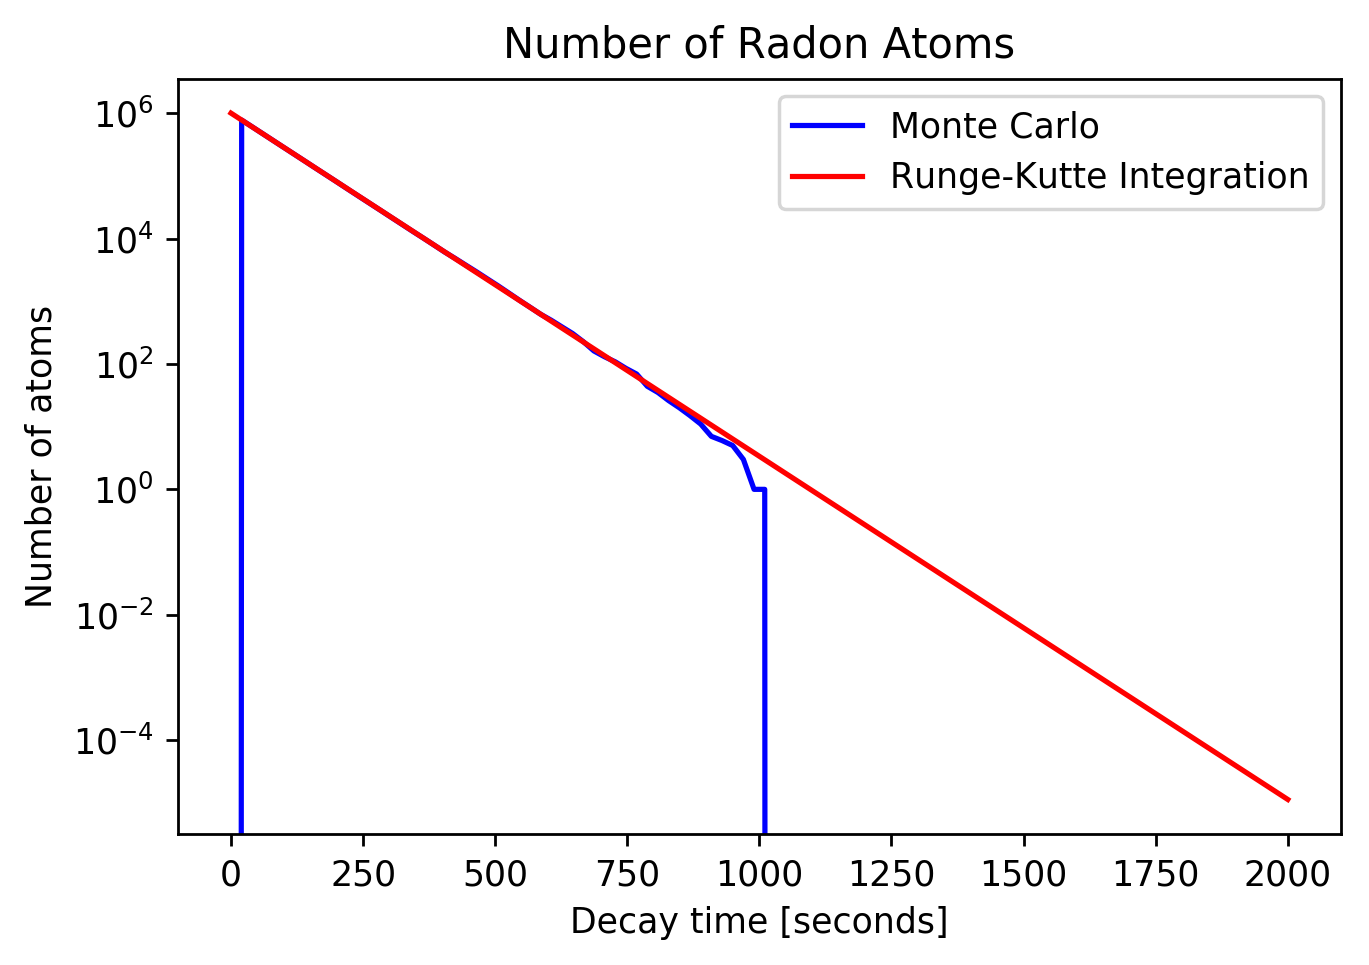

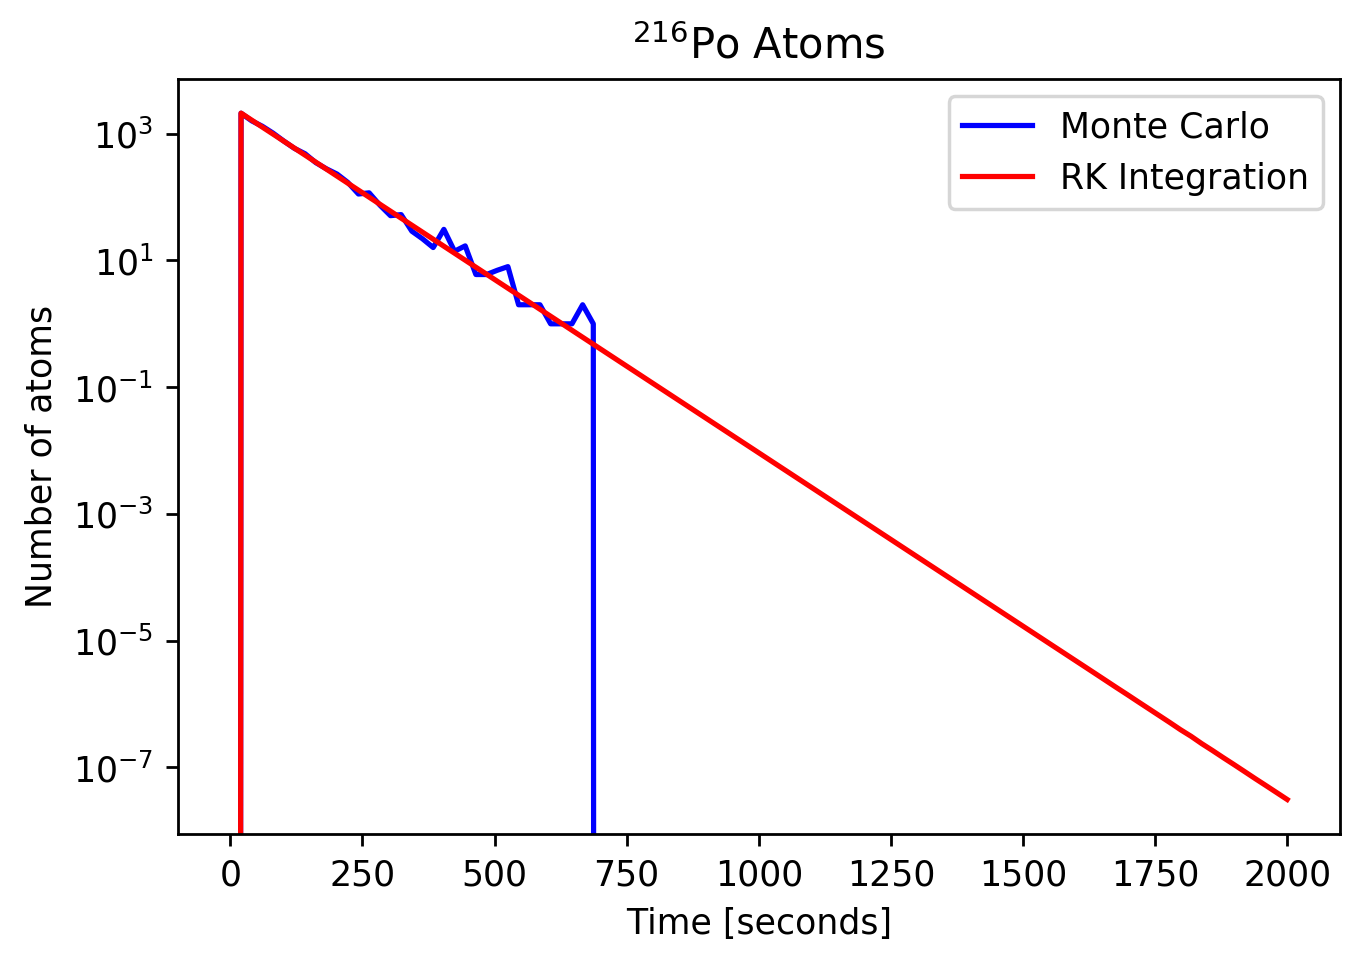

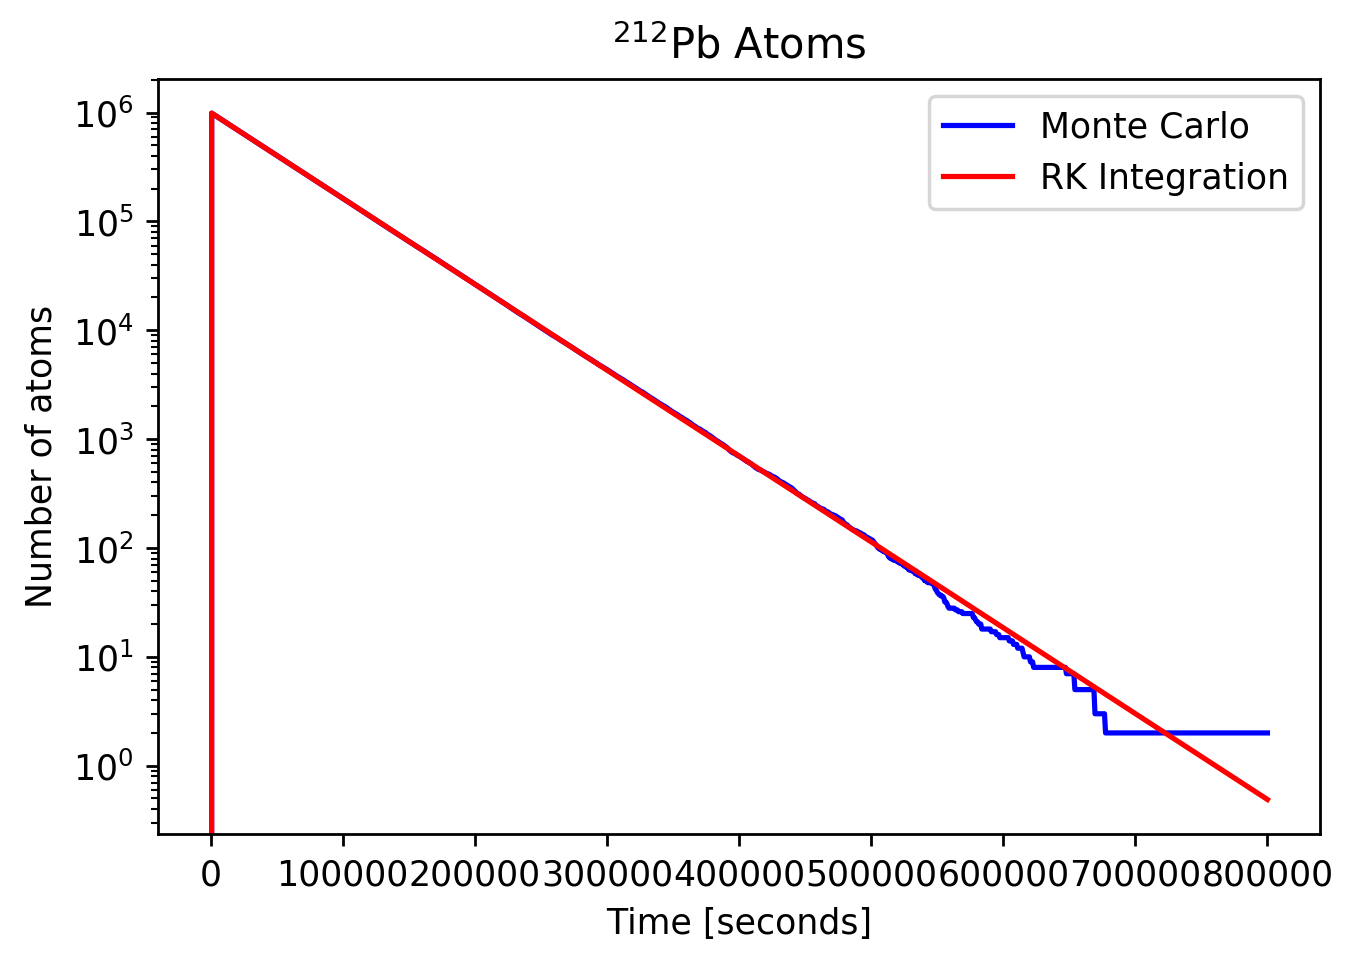

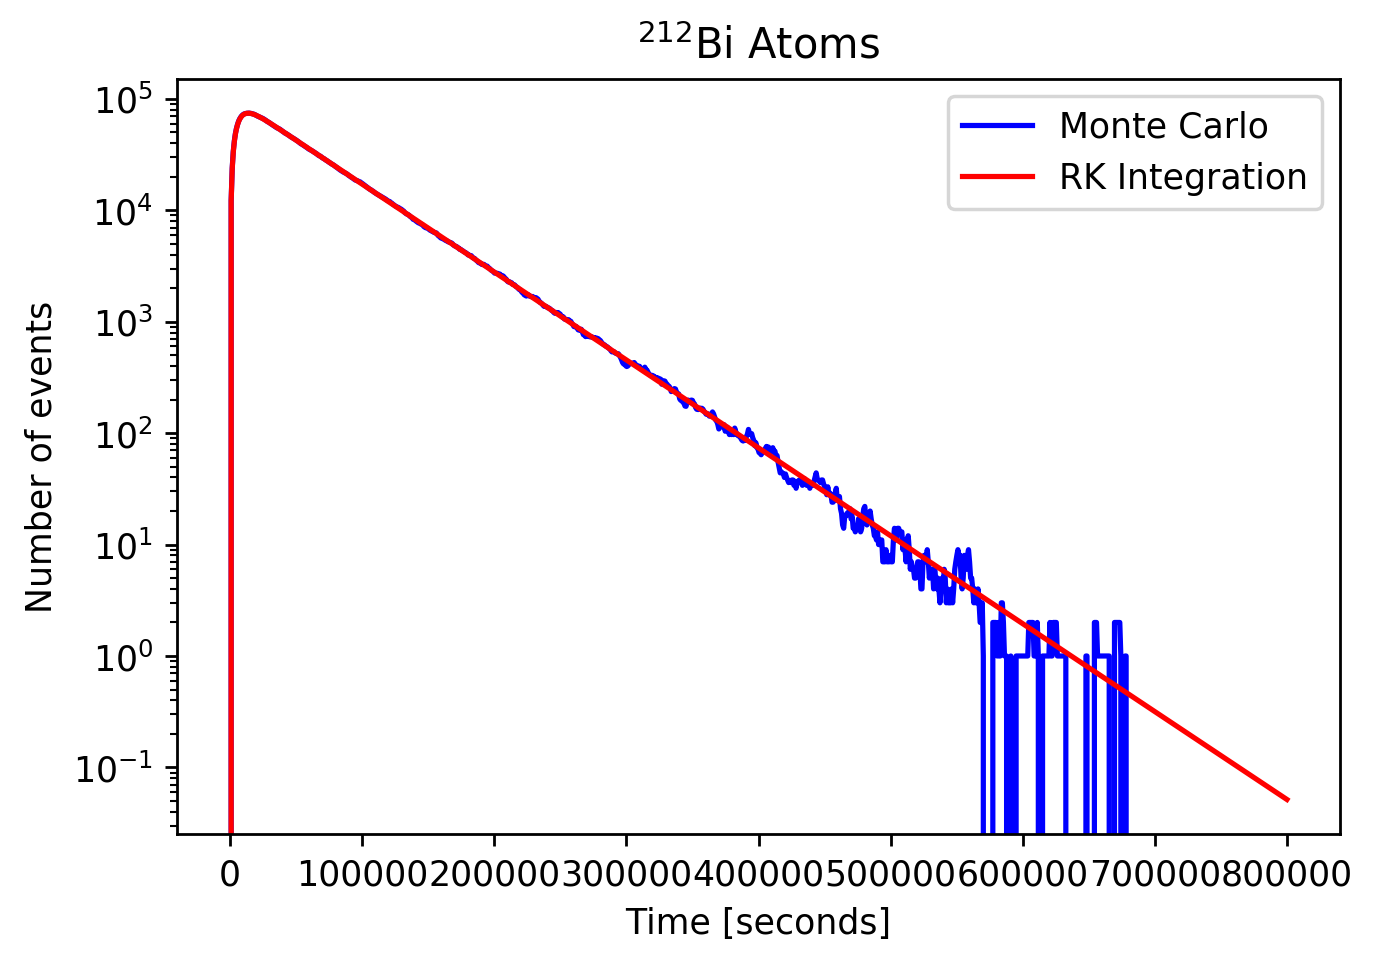

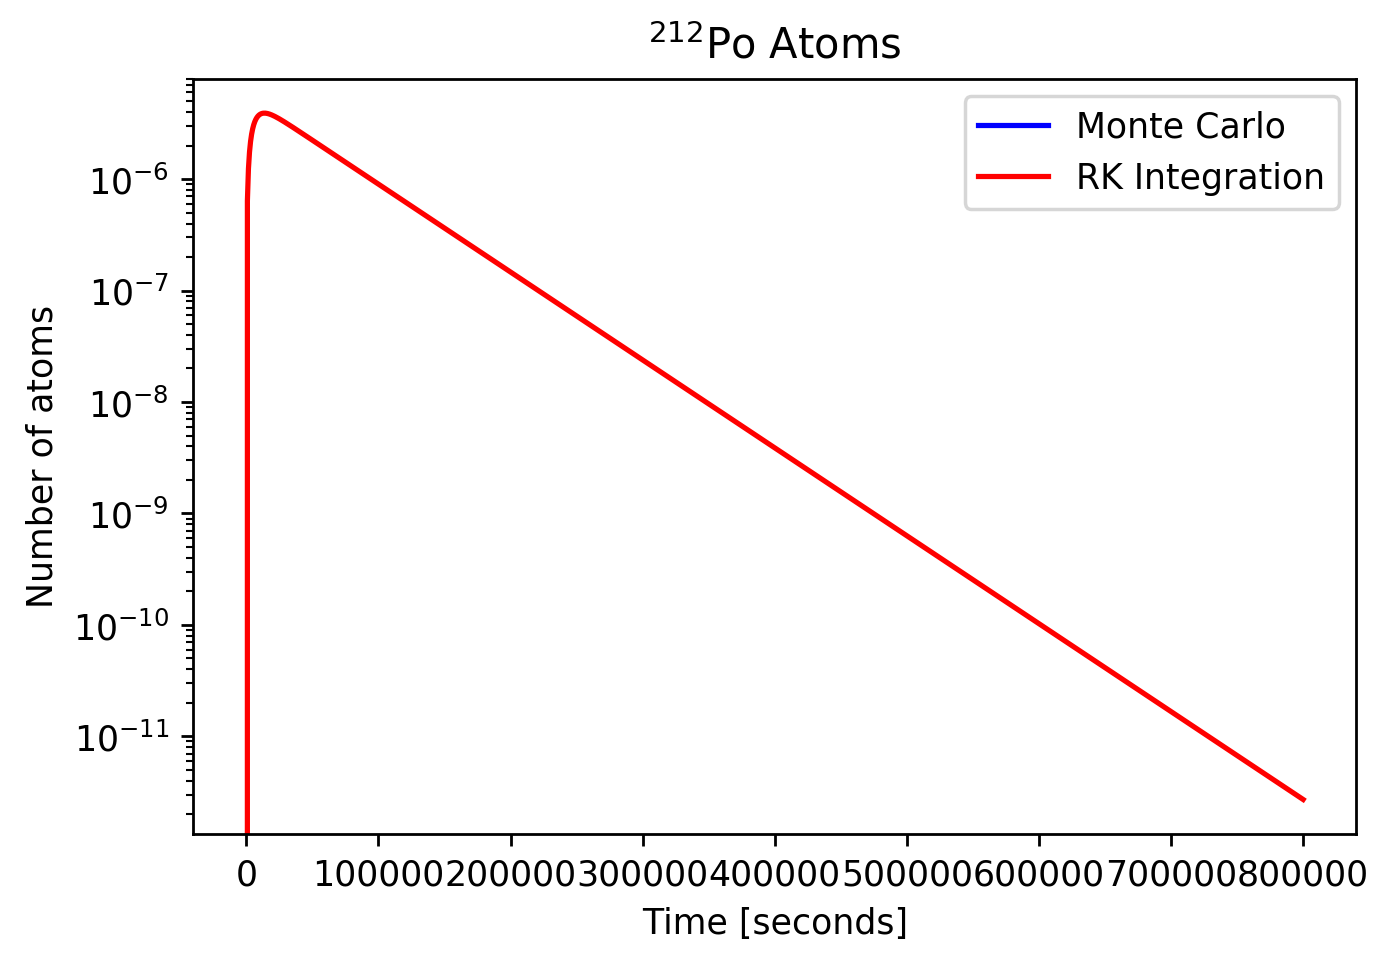

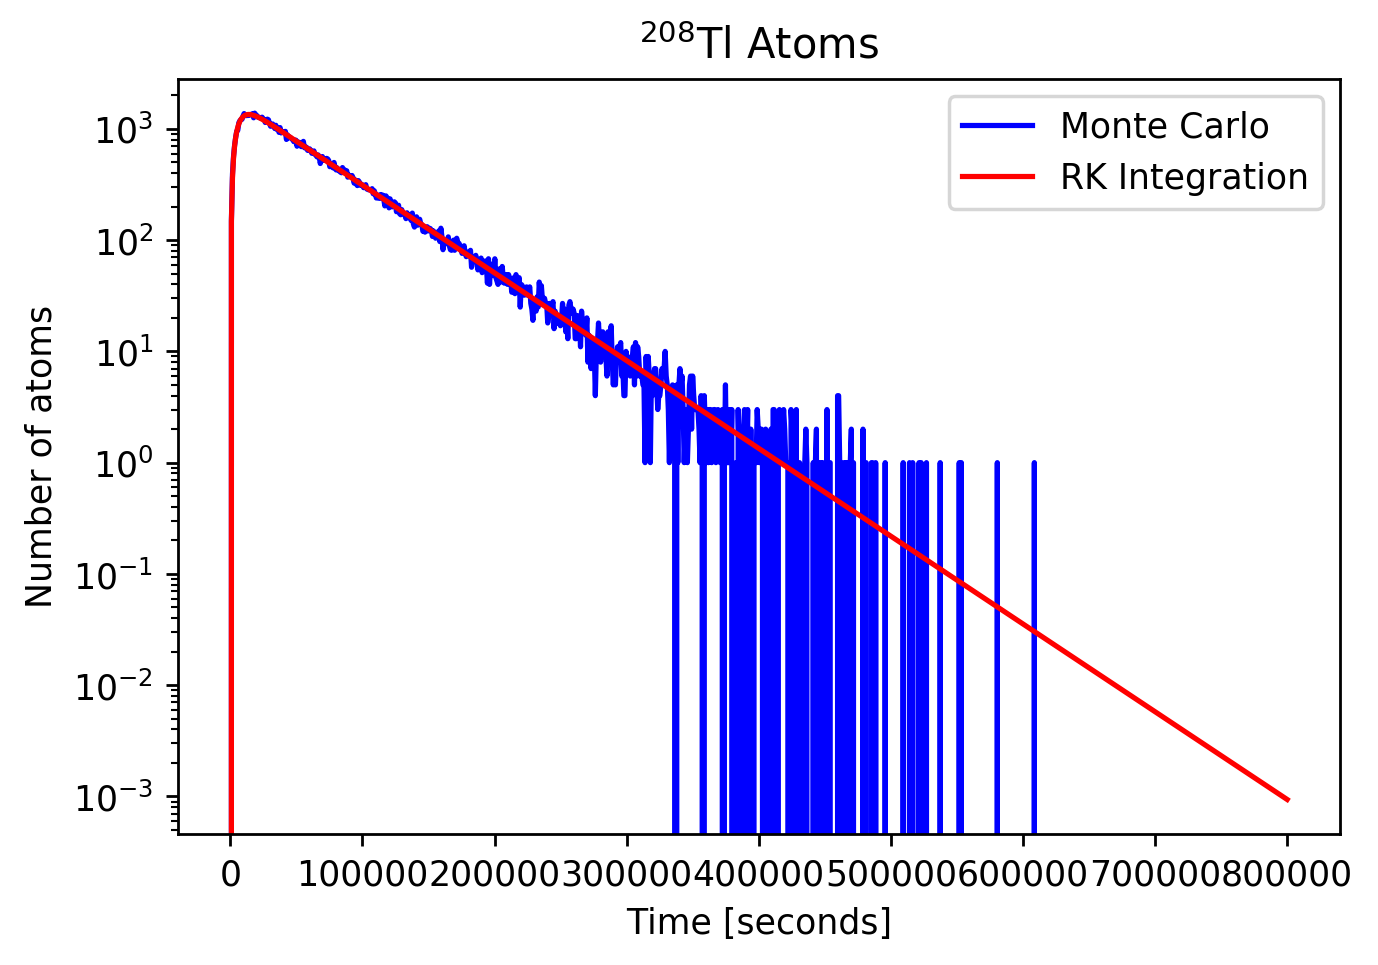

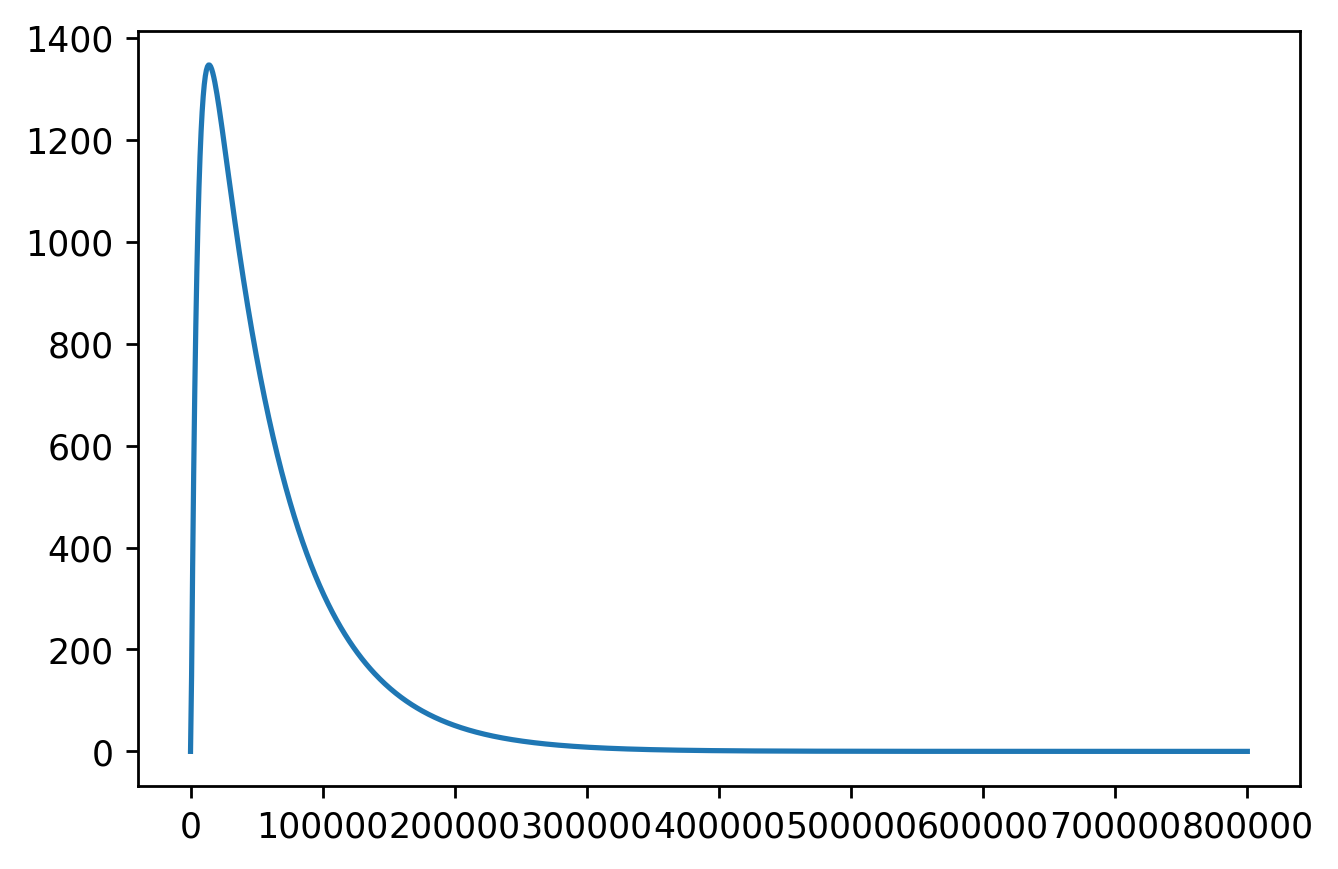

In [29]:
tzero=np.zeros(len(radonDecayTime))
plt.figure()
#plt.hist(radonDecayTime,1000)
plt.plot(tzoom,N(tzoom,tzero,radonDecayTime),'b',label='Monte Carlo')
plt.plot(tzoom,solutionZoom[:,0].reshape(-1),'r',label='Runge-Kutte Integration')
#print(N(t[range],0,radonDecayTime))
plt.title('Number of Radon Atoms')
plt.xlabel('Decay time [seconds]')
plt.ylabel('Number of atoms')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.plot(tzoom,N(tzoom,radonDecayTime,po216DecayTime),'b',label='Monte Carlo')
plt.plot(tzoom,solutionZoom[:,1].reshape(-1),'r',label='RK Integration')
plt.title(r'$^{216}$Po Atoms')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.plot(t,N(t,po216DecayTime,pb212DecayTime),'b',label='Monte Carlo')
plt.plot(t,solution[:,2].reshape(-1),'r',label='RK Integration')
plt.legend()
plt.title(r'$^{212}$Pb Atoms')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(t,N(t,pb212DecayTime,bi212DecayTime),'b',label='Monte Carlo')
plt.plot(t,solution[:,3].reshape(-1),'r',label='RK Integration')
plt.legend()
plt.title(r'$^{212}$Bi Atoms')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of events')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(t,N(t,bipoTime,po212DecayTime),'b',label='Monte Carlo')
plt.plot(t,solution[:,4].reshape(-1),'r',label='RK Integration')
plt.legend()
plt.title(r'$^{212}$Po Atoms')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.yscale('log')
plt.show()

plt.figure()
plt.plot(t,N(t,bitlTime,tl208DecayTime),'b',label='Monte Carlo')
plt.plot(t,solution[:,5].reshape(-1),'r',label='RK Integration')
plt.legend()
plt.title(r'$^{208}$Tl Atoms')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')
plt.yscale('log')
plt.show()


plt.figure()
plt.plot(t,solution[:,5])
plt.title(r'$^{208}$Tl Atoms (by integration)')
plt.xlabel('Time [seconds]')
plt.ylabel('Number of atoms')

Does the plot for $^{212}$Po make sense?



### Stochastic modelling

We see that the Runge-Kutta integration works well when the number of atoms are large.  But there are a set of questions we can ask that depend upon the *random* nature of the fundamental process in a Monte Carlo calculation, but that we can't answer with just the probability distribution.  

So, for instance, we can make the distribution of the time of the last decay.  How do we do that?  We do the experiment N times (inside the computer), and make a histogram of when the last atom decays.  To make this take a reasonable amount of time, let's run the MC experiment 1000 times, starting with 10000 Radon atoms and seeing when the last one decays.  

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


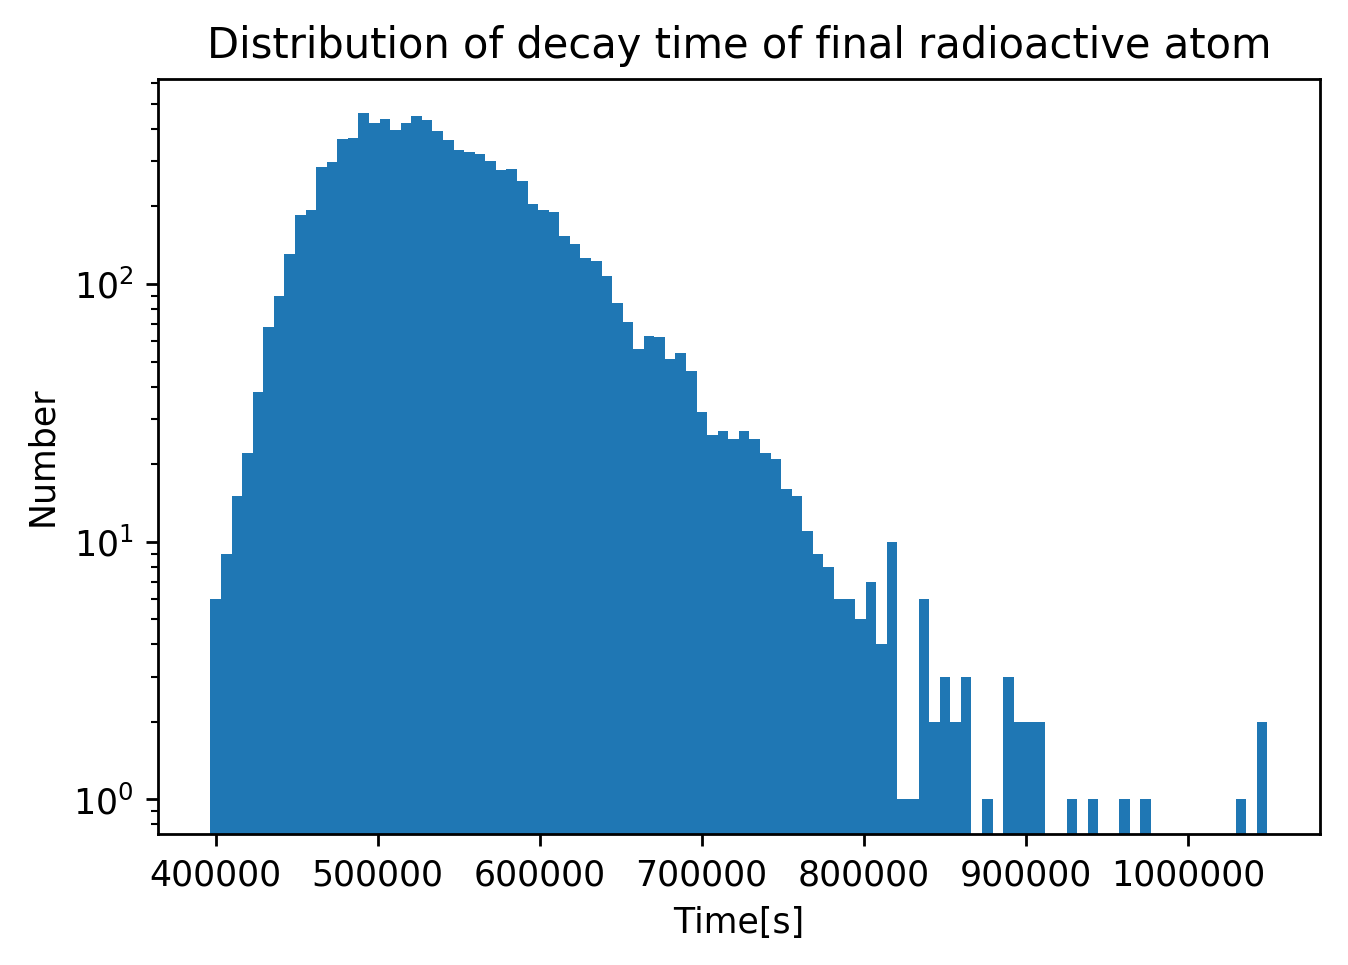

In [39]:
nAtoms=10000
nExperiments=10000
tdist=np.zeros(nExperiments)
for experimentIndex in np.arange(0,nExperiments):
    radon=np.random.exponential(1/lambdaRn,nAtoms)
    scalePo216=0.15/np.log(2)
    po216=np.random.exponential(scalePo216,nAtoms)
    scalePb212=10.6*3600/np.log(2)
    pb212=np.random.exponential(scalePb212,nAtoms)
    scaleBi212=60.6*60/np.log(2)
    bi212=np.random.exponential(scaleBi212,nAtoms)
    # here we generate a branch variable, which decides which one of two ways to go
    branch=np.random.rand(nAtoms)
    scalePo212=299e-9/np.log(2)
    po212=np.random.exponential(scalePo212,nAtoms)# generate all to begin with
    po212[np.where(branch>=0.64)]=0
    scaleTl208=3.05*60/np.log(2)
    tl208=np.random.exponential(scaleTl208,nAtoms)# generate all to begin with
    tl208[np.where(branch<=0.64)]=0

    t=radon+po216+pb212+bi212+po212+tl208
    tdist[experimentIndex]=np.max(t)
    if experimentIndex%500 == 0:
        print(experimentIndex)
    
plt.figure()
plt.hist(tdist,100)
plt.title('Distribution of decay time of final radioactive atom')
plt.xlabel('Time[s]')
plt.ylabel('Number')
plt.yscale('log')

Notice that the distribution is nothing like a gaussian distribution- it is asymmetric and extends much further to long times than to short times.

What is the probability that the last radon decays more than a million seconds after the injection?  

Of course there are many similar questions we can answer with "multiple experiments". 


### Frequentist and Bayesian Statistics

With the wide spread use of MC, and the ability to generate multiple data sets, we can answer the question:  if the distributions of parameters are known, what are the distributions of *measurements*?  This is the central question of *frequentist* statistics, and can be answered rigorously with MC calculations.  (cf.  John Bahcall's 1000 solar models)

Frequentists talk about "distributions of measurements".  Bayesians talk about "probabilities of parameters".  Both are correct but reveal different aspects of measurements.  So for instance-- one knows a mass can't be negative (to start with).  But an experiment that has a distribution can result in a *mass measurement* that is negative.  

Independent of philosophy, MC techniques like this allow one to probe complex distributions and make inferences about measurements without assumptions of normal distributions, or high statistics, etc. etc.  